# Proyecto 03 - Sistemas de Recomendación

#### Implementación de un Sistema de Recomendación para videojuegos de la plataforma Steam.

**El dataset de STEAM se puede descargar desde [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

Este proyecto se puede encontrar en mi **[git](https://github.com/gonzalogperez/sistemas-recomendacion-steam/blob/main/GonzaloGPerezProyecto_3.ipynb)**

### Tabla de Contenidos <a class="anchor" id="TOC"></a>

* [Exploración de Datos](#chapter1)
    * [a. Explora la fuente de datos](#section_1_1)
    * [b. Análisis exploratorio](#section_1_2)
        * [Dataset Reviews](#section_1_2_1)
        * [Dataset Games](#section_1_2_2)
    * [c. Nulls y Columnas que no aportan información](#section_1_3)
    * [d. Transformaciones](#section_1_4)
         * [d.1 Top horas jugadas y cantidad de usuarios](#section_1_4_1)
         * [d.2 Boxplot para ver la distribución de las horas jugagas por juegos, se elije el top-20 para mostrars](#section_1_4_2)
         * [d.3 Removemos los Outliers](#section_1_4_3)
         * [d.4 Ingenieria de Feature: Creación del Rating](#section_1_4_4)
         * [d.5 Observamos la distribución de las calificaciones](#section_1_4_5)
         * [d.6 Encode: Obtención rectangulo de datos](#section_1_4_6)
    * [e. Gráficos interpretación y entendimiento de datos](#section_1_5)
         * [e.1 La distribución de las horas según el juego - Top 20](#section_1_5_1)
         * [e.2 La cantidad de usuarios agrupados en bins según en precio](#section_1_5_2)
         * [e.3 La Distribucion de los precios de los juegos](#section_1_5_3)
         * [e.4 La Cantidad de videos Juegos por usuarios](#section_1_5_4)
         * [e.5 El Juego más comprado es el más Jugado?](#section_1_5_5)
         * [e.5 El Juego más comprado es el más Jugado? solo los jugados](#section_1_5_6)
* [Modelo Machine Learning](#chapter2)
     * [f. Desarrollo del Modelo](#section_2_1)
         * [f.1 Filtro Coloborativo (con Surprise)](#section_2_1_1)
         * [f.2 Metrica](#section_2_1_2)
         * [f.3 Algoritmos](#section_2_1_3)
         * [f.4 Manos a la obra con Surprice](#section_2_1_4)
         * [f.5 Creamos un Benchmark (Small Data)](#section_2_1_5)
         * [f.6 Train y Predict con (Big Data)](#section_2_1_6)
         * [f.7 Cross Validation](#section_2_1_7)
    * [g. Optimización Hiperparámetros](#section_2_2)
         * [g.1 Top-10 recommendations para cada usuario](#section_2_2_1)      
    * [h. Comparacion con el modelo elegido de Benchmark ](#section_2_3)
    * [i. Información para predecir](#section_2_4)
         * [i.1 Como se realizan las predicciones](#section_2_4_1)
         * [i.2 Predicciones igual a las más populares?](#section_2_4_2)
* [Investigación](#chapter3)
    * [j. Plantea nuevas preguntas en base al trabajo que hiciste y en las que se pueda ahondar](#section_3_1)
    * [k. Plantea un flujo de trabajo que responda alguna o algunas de esas preguntas](#section_3_2)
* [Requerimientos Adicionales](#chapter4)
    * [l. Implementa el flujo de trabajo planteado](#section_4_1)
         * [l.1 Cold Start](#section_4_1_1)      
         * [l.2 Predicciones en Big Data?](#section_4_1_2)
         * [l.3 Conclusiones](#section_4_1_3)      

### Exploración de Datos <a class="anchor" id="chapter1"></a>

#### a. Explora la fuente de datos <a class="anchor" id="section_1_1"></a>
[Tabla de contenidos](#TOC)

In [ ]:
### Importamos librerias
##!pip install  surprise
import gzip
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#Barra de progreso
##conda install tqdm
#from tqdm import tqdm
from tqdm.notebook import tqdm
from surprise import Reader, Dataset, SVD
from IPython.display import Image
from IPython.core.display import HTML 

In [4]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

Tenemos dos dataset, uno es con las reviews de los usuarios a los juegos y otra con las descripciones de cada juego. El objetivo es adecuar los datos para poder crear un modelo con filtro colaboratibo utilizando la librería `surprise`, la cual requiere como datos de entrada las features:  users, items, ratings, por ellos durante el proceso se irá filtrando/ descartando features que no se crean relevantes para construir el rating, algunas features se dejan por la posibilidad de construir el score de alguna otra forma en un futuro.

**Dataset Reviews**

In [5]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 10
for l in parse('data/steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1

In [6]:
data_reviews = pd.DataFrame(data_reviews)

In [7]:
if True:
    data_reviews.to_csv('data/data_reviews.csv', index= False)

Cargamos el dataset

In [6]:
data_reviews = pd.read_csv('data/data_reviews.csv')
data_reviews.head(5)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,7.656120e+16,Product received for free,NaN
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,7.656120e+16,NaN,NaN


El dataset de las reviews contiene 12 Features: 
- username: nombre del usuarios
- hours: horas jugadas 
- products: sin información
- product_id: número que identifica al producto, es decir, al juego
- page_order: en que número de página aparece el juego
- date: fecha de de la review del juego
- text: comentario sobre el juego
- early_access: sin información
- page: sin información
- user_id: identificador único de usuario
- compensation: productos recibidos gratuitamente.
- found_funny: sin información

**Dataset Games**

In [35]:
data_games = []
for l in parse('data/steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [36]:
#Guardamos el dataset en csv
if True:
    data_games.to_csv('data/data_games.csv', index= False)

In [4]:
#Cargamos el dataset desde el CSV
data_games = pd.read_csv('data/data_games.csv')
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",4.49,http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,False,761140.0,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"['Action', 'Adventure', 'Casual']",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"['Action', 'Adventure', 'Casual']",0.83,http://steamcommunity.com/app/767400/reviews/?...,['Single-player'],0.99,False,767400.0,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"['Action', 'Indie', 'Casual', 'Sports']",1.79,http://steamcommunity.com/app/773570/reviews/?...,"['Single-player', 'Full controller support', '...",2.99,False,773570.0,NaN,NaN,NaN


El dataset games, tiene 32135 Juegos y 16 Features:

- publisher: editor del juego
- geners: el genero del juego
- app_name: nombre del juego
- title: Titulo del juego
- url: link del juego
- release_date: fecha de lanzamiento
- tags: etiquetas, como genero y si es gratuito o no.
- discount_price: si tiene el descuento y cual es su valor
- revies_url: link de las reviews
- spec: si es sigle, multi, online player, etc.
- price: precio
- early_access: acceso mientras el juegoevoluciona (desarrollo)
- id: identificador numérico del juego
- developer: desarrollador del juego
- sentiment: calificación del juego en general
- metascore: score del juego


#### b. Análisis exploratorio <a class="anchor" id="section_1_2"></a>
##### **Dataset Reviews** <a class="anchor" id="section_1_2_1"></a>

[Tabla de contenidos](#TOC)

In [7]:
# Obtenemos el tamaño del dataset
data_reviews.shape

(779307, 12)

In [17]:
#Cantidad de usuarios
data_reviews.username.nunique()

540338

In [8]:
#Cantidad de reviews de usuarios a juegos, nos dará la catidad de juegos únicos que recibieron reviews por parte de los usuarios

In [19]:
data_reviews.product_id.nunique()

12665

El dataset contiene 779307 reviews, 540338 usuarios únicos y 12665 juegos que recibieron reviews

In [20]:
data_reviews.isna().sum()

username            18
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text              1839
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

Se observar que las features, `user_id` tiene 59% de los datos nulos, no nos interesa porque podemos emplear la feature `username` en su reemplazo. `compensation` tiene el 98.12% de elementos faltantes y `found_funny` el 84.58% de faltantes. Estas features no serán consideradas por el gran número de faltantes.
A continuación obsevamos las características descriptivas (estadísticas) de las features numéricas.

In [21]:
data_reviews.describe()

,hours,products,product_id,page_order,page,user_id,found_funny
count,776670.000000,777741.000000,779307.000000,779307.000000,779307.000000,3.173400e+05,120164.000000
mean,111.843832,236.993936,251489.822053,4.417743,893.581355,7.656120e+16,7.713125
std,390.145376,486.034479,149975.370469,2.897848,1928.272966,1.007694e+08,72.465816
min,0.000000,1.000000,10.000000,0.000000,1.000000,7.656120e+16,1.000000
25%,4.000000,45.000000,203770.000000,2.000000,53.000000,7.656120e+16,1.000000
50%,15.300000,110.000000,252490.000000,4.000000,238.000000,7.656120e+16,1.000000
75%,59.600000,246.000000,346110.000000,7.000000,829.000000,7.656120e+16,3.000000
max,28164.000000,13540.000000,773900.000000,9.000000,18371.000000,7.656120e+16,6524.000000


Las horas promedio de juego son 111,8 horas, pero el 75% de los usuarios se encuentra por debajo de las 59.6 Horas de Juego presentando un valor máximo de 28164 Horas, lo cual disorciona el promedio. page_order se puede concluir que el 50% de los juegos son adquiridos estando antes de la página 4 de la plataforma. El resto de las features no tiene setido el analisis porque algunas se descartarán o son variables numéricas que identifican a usuario y/o Items

#### Pairplot para ver la distribución de todas las variables

In [22]:
data_reviews = data_reviews.drop(columns = ['user_id', 'compensation','found_funny'])

In [24]:
data_reviews

,username,hours,products,product_id,page_order,date,text,early_access,page
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1
...,...,...,...,...,...,...,...,...,...
779302,Vidaar,783.5,353.0,252490,1,2013-12-11,Summary: Rust is a survival game created by Fa...,True,10217
779303,Nikolai Belinski,55.1,204.0,252490,1,2013-12-11,Coolest Game Eva,True,10218
779304,RancorZealot,203.5,173.0,252490,1,2013-12-11,Should you buy RUST? Uh... YES. The BEST Survi...,True,10219
779305,Jerry,139.8,79.0,252490,1,2013-12-11,Great game!,True,10220


In [28]:
dataplot = data_reviews[['hours','page_order','page','early_access']]

/home/gonperez/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


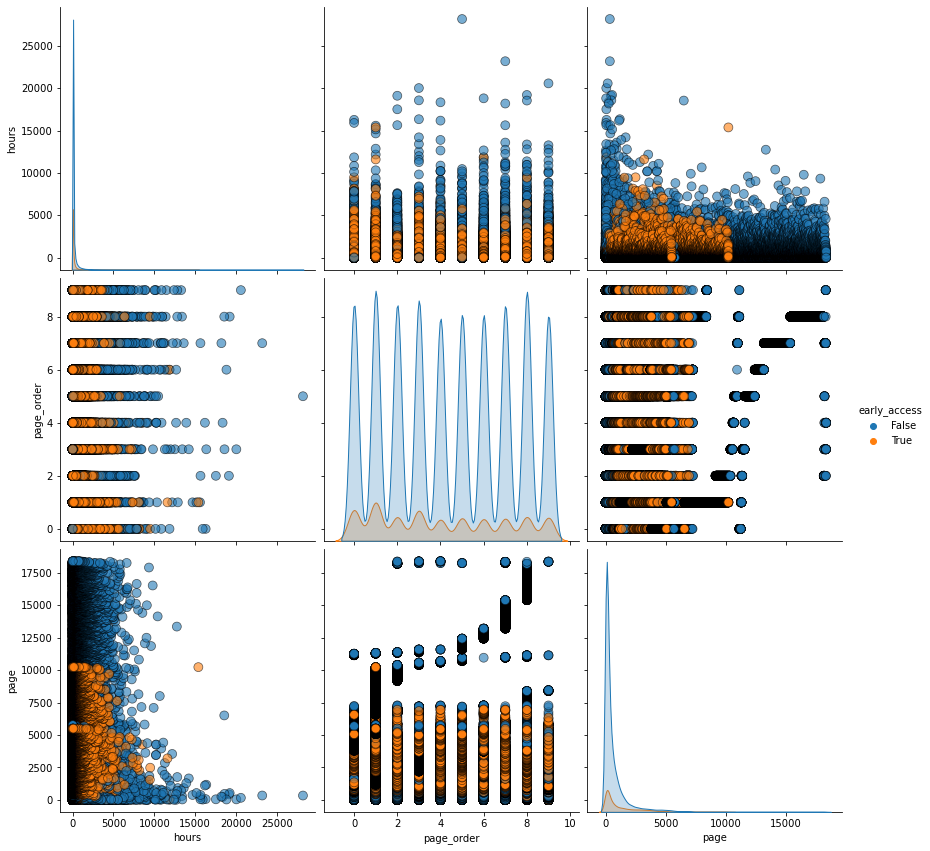

In [29]:
sns.pairplot(dataplot, hue = 'early_access', diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             size = 4)
plt.show()

Se observa que la concentración de horas jugadas es menor a 30000, se hizo agrupación si el juego era early_access, que son los juegos que te dan acceso mientra aún continúa el desarrollo, de ahí se observa que los que caen dentro de esta categoría se encuentran dentro de las primeras 10000 páginas, después de ese número no se observan juegos con esa característica. Además estos juegos, una gran parte no supera las 5000 horas de juego, que si lo hacen los que no son early_media.

##### **Dataset Games** <a class="anchor" id="section_1_2_2"></a>
[Tabla de contenidos](#TOC)

In [39]:
## Tamaño del dataset
data_games.shape

(32135, 16)

In [26]:
## Cantidad de Juegos
data_games.app_name.nunique()

32094

In [16]:
# Observamos los nulos
data_games.isna().sum()

id             0
app_name       1
price       1377
genres      3282
tags         162
specs        669
dtype: int64

Se observa que el 91% de los datos de metascore son faltantes, el 22% de sentiment y solo el 1% tienen cargados descuentos.

In [17]:
#vemos los tipos de datos:
data_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32133 entries, 0 to 32132
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        32133 non-null  int64 
 1   app_name  32132 non-null  object
 2   price     30756 non-null  object
 3   genres    28851 non-null  object
 4   tags      31971 non-null  object
 5   specs     31464 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.5+ MB


No se realiza analisis estadístico de las variables porque son variables categóricas, salvo el id que no tiene sentido su análisis.

In [18]:
#No dropeamos, solo temamos las líneas en que el id no es NA:
data_games = data_games[data_games['id'].notna()]
data_games['id'] = data_games['id'].astype('int')
data_games.reset_index(inplace=True)

Seleccionamos las features relevantes de los dataset para posterior hacer un merge entre ambos y trabajar con uno solo

In [19]:
data_reviews = data_reviews[['product_id','username', 'hours', 'products']]

In [20]:
data_games = data_games[['id','app_name','price','genres','tags','specs']]

In [21]:
data_reviews.head(3)

,product_id,username,hours,products
0,725280,Chaos Syren,0.1,41.0
1,328100,Ariman1,13.2,1386.0
2,725280,freakfantom,0.1,1706.0


In [22]:
data_games.head(3)

,id,app_name,price,genres,tags,specs
0,761140,Lost Summoner Kitty,4.99,"['Action', 'Casual', 'Indie', 'Simulation', 'S...","['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",['Single-player']
1,643980,Ironbound,Free To Play,"['Free to Play', 'Indie', 'RPG', 'Strategy']","['Free to Play', 'Strategy', 'Indie', 'RPG', '...","['Single-player', 'Multi-player', 'Online Mult..."
2,670290,Real Pool 3D - Poolians,Free to Play,"['Casual', 'Free to Play', 'Indie', 'Simulatio...","['Free to Play', 'Simulation', 'Sports', 'Casu...","['Single-player', 'Multi-player', 'Online Mult..."


Realizo merge de los dos dataset

Agregamos al dataset el nombre del Juego, se utiliza la columna en común que identifica a los juegos en ambos dataset, product_id y id

In [23]:
#https://interactivechaos.com/es/manual/tutorial-de-pandas/dataframes-la-funcion-merge
mergeado = pd.merge(data_reviews,data_games, left_on = "product_id", right_on = "id")
mergeado.drop('id', axis=1, inplace=True)
mergeado.head()

,product_id,username,hours,products,app_name,price,genres,tags,specs
0,725280,Chaos Syren,0.1,41.0,Psi Project,2.99,"['Action', 'Adventure', 'Indie', 'Simulation']","['Action', 'Adventure', 'Indie', 'Simulation']","['Single-player', 'Steam Trading Cards']"
1,725280,freakfantom,0.1,1706.0,Psi Project,2.99,"['Action', 'Adventure', 'Indie', 'Simulation']","['Action', 'Adventure', 'Indie', 'Simulation']","['Single-player', 'Steam Trading Cards']"
2,328100,Ariman1,13.2,1386.0,Gunspell - Steam Edition,14.99,"['Adventure', 'Indie', 'RPG']","['Adventure', 'RPG', 'Indie', 'Puzzle', 'Match...",['Single-player']
3,328100,dll3z,0.4,314.0,Gunspell - Steam Edition,14.99,"['Adventure', 'Indie', 'RPG']","['Adventure', 'RPG', 'Indie', 'Puzzle', 'Match...",['Single-player']
4,328100,Nyazicat,2.2,1224.0,Gunspell - Steam Edition,14.99,"['Adventure', 'Indie', 'RPG']","['Adventure', 'RPG', 'Indie', 'Puzzle', 'Match...",['Single-player']


In [24]:
# Guardamos el dataset que realizamos merge para ser utilizados luego
if True:
    mergeado.to_csv('data/mergeado.csv', index= False)

#### c. Nulls y Columnas que no aportan información <a class="anchor" id="section_1_3"></a>
[Tabla de Contenidos](#TOC)

Como se mencionó anteriormente, el objetivo es adecuar los datos para poder crear un modelo con filtro colaboratibo utilizando la librería `surprise`, la cual requiere como datos de entrada las features:  users, items, ratings, por ellos durante el proceso se irá filtrando/ descartando features que no se crean relevantes para construir el rating, algunas features se dejan por la posibilidad de construir el score de alguna otra forma en un futuro.

Resumiendo, a partir de ahora se trabaja con el dataset en el que se realizó el merge de los dos datset disponibles (reviews y games) para tener principalmente las siguientes features: 
product_id, app_name,username y hours descartando el resto.

#### d. Transformaciones <a class="anchor" id="section_1_4"></a>
[Tabla de contenidos](#TOC)

Cargamos el Dataset, que ya contiene un merge con las reviews y games. Además cargamos el dataset data_games. Esto lo hacemos para liberar el CPU/RAM. Al cargar ya los dataset filtrados previamente se reinició el Kernel

In [48]:
df = pd.read_csv('data/mergeado.csv')
data_games = pd.read_csv('data/data_games.csv')
#df.head(2)

In [49]:
## Tamaño del dataset
df.shape

(779951, 9)

In [51]:
df1 = df[['product_id','username','app_name','price','hours']]
df1

,product_id,username,app_name,price,hours
0,725280,Chaos Syren,Psi Project,2.99,0.1
1,725280,freakfantom,Psi Project,2.99,0.1
2,328100,Ariman1,Gunspell - Steam Edition,14.99,13.2
3,328100,dll3z,Gunspell - Steam Edition,14.99,0.4
4,328100,Nyazicat,Gunspell - Steam Edition,14.99,2.2
...,...,...,...,...,...
779946,518790,rt974,theHunter: Call of the Wild™,29.99,9.4
779947,518790,Fallenglory,theHunter: Call of the Wild™,29.99,35.8
779948,518790,GooseMan,theHunter: Call of the Wild™,29.99,32.4
779949,518790,lazyboy82,theHunter: Call of the Wild™,29.99,96.9


In [52]:
cnt_de_juegos = df1['product_id'].unique().size
cnt_usuarios = df1['username'].unique().size
print("El dataset tiene {} juegos y {} usuarios".format(cnt_de_juegos,cnt_usuarios))

El dataset tiene 12665 juegos y 540339 usuarios


#### d.1 Top horas jugadas y cantidad de usuarios<a class="anchor" id="section_1_4_1"></a>
[Tabla de contenidos](#TOC)

Creamos un dataframe con el nombre del juego, el acumulado de horas jugadas por todos los usuarios y la cantidad de usuarios

In [53]:
# Total de número de horas y total de número de usuarios por juego
#user_count = df_data_users.loc[df_data_users[col_play] == 1]. \
#        groupby(col_game)[col_user].agg('count').sort_values(ascending=False)
user_count = df1.groupby('app_name')['username'].agg('count').sort_values(ascending=False) 
# hours_played = df_data_users.loc[df_data_users[col_play] == 1]. \
#        groupby(col_game)[col_hour].agg(np.sum).sort_values(ascending=False)
hours_played = df1.groupby('app_name')['hours'].agg(np.sum).sort_values(ascending=False) 

In [54]:
# Creamos el dataframe con los más jugados con el total de horas y total de usuarios por juego    
nb_games=20
df_top_hours_played = pd.DataFrame({'app_name': hours_played.index,
                                        'hours_played': hours_played.values,
                                        'user_count': user_count.values})[0:nb_games]

In [55]:
df_top_hours_played

,app_name,hours_played,user_count
0,Team Fortress 2,13306145.4,18373
1,Rust,4443474.6,10221
2,Warframe,3406654.9,7321
3,Garry's Mod,2629495.2,7113
4,Arma 3,2573904.2,5976
5,ARK: Survival Evolved,2275927.5,5710
6,Fallout 4,1635305.7,5518
7,Mount & Blade: Warband,1446695.2,5518
8,Counter-Strike: Source,1417299.9,5496
9,DayZ,1348023.4,5301


#### d.2 Boxplot para ver la distribución de las horas jugagas por juegos, se elije el top-20 para mostrars<a class="anchor" id="section_1_4_2"></a>
[Tabla de contenidos](#TOC)

In [56]:
# Get column names from csv.
col_names = df1.columns
col_names

Index(['product_id', 'username', 'app_name', 'price', 'hours'], dtype='object')

In [57]:
# Mask criteria for box plot.
#mask_criteria = df1[col_game].isin(df_top_hours_played['game_name'])
df_box_plot = df1[['hours', 'app_name']]

In [58]:
nb_games=20

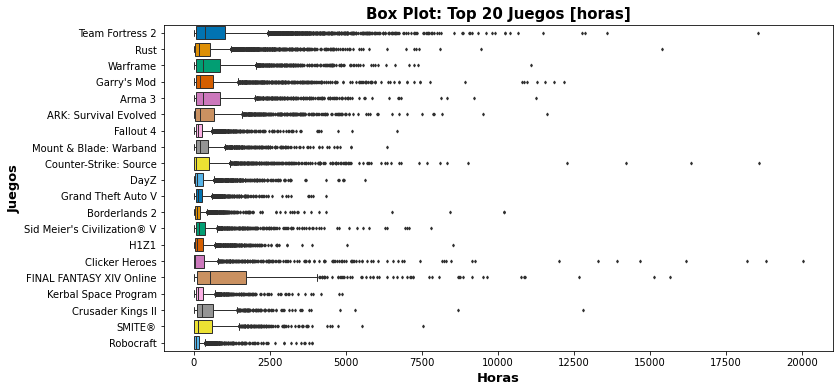

In [59]:
# Creación de box-plot.
fig_h = 1 + 0.25 * max(1, nb_games)
fig, ax = plt.subplots(figsize=(12, fig_h))
sns.set_style("whitegrid")
ax = sns.boxplot(x='hours', y='app_name', data=df_box_plot,
                 order=df_top_hours_played['app_name'].to_list(),
                 palette="colorblind",
                 saturation=1,
                 linewidth=1,
                 fliersize=2)
plt.title('Box Plot: Top {} Juegos [horas]'.format(nb_games),fontsize=15, fontweight='heavy')
plt.xlabel('Horas', fontsize=13, fontweight='demi')
plt.ylabel('Juegos', fontsize=13, fontweight='demi')
plt.show()

In [60]:
df_box_plot.describe()

,hours
count,777314.000000
mean,111.765730
std,389.993556
min,0.000000
25%,4.000000
50%,15.300000
75%,59.500000
max,28164.000000


Para entender mejor la información de los usuarios y sus hábitos de juego, el boxplot anterior muestra el top 20 de los juegos más jugados, basado en el total de horas jugadas.

Se observa, que la distribución de la información de cada juego no es simetrica (no es normal). Mirando más en detalle, los valores fuera de los bígotes, los puntos de cada juego se encuentra en el rango de miles de horas de juego, exponiendo los outliers o valores atípicos. Por ejemplo, Team Fortress 2, un usuario jugó más de  18000 horas, o el Juego Clicker Heroes, hay un usuario jugó más de 20000 horas, que son aproximandamente más de 6 años jugando al mismo juego unas 8 por día.

#### d.3 Removemos los Outliers<a class="anchor" id="section_1_4_3"></a>
[Tabla de contenidos](#TOC)

In [95]:
### Filtrar outliers por juego
## Funcion para obtener filtrar los outliers, pasando el dataframe y la columna
#df_new=[]
#result_total = pd.DataFrame(columns=['A','B','C','D','E','F','G'])
#result_total = pd.DataFrame(columns=[df1.columns])
df_new = pd.DataFrame()

def remove_outlier(df_in, col_name,nombre):
    '''
    Dado un dataframe (df_in) devuelve el mismo pero
    filtrado por los límites superiores e inferiores
    según el críterio de los rangos intercuartilicos * 1.5.
    
    Arguments:
    df_in -- dataframe a filtrar
    col_name -- columna por la cual se va a filtrar los datos, valores discretos
    tipo -- tipo de propiedad para filtrar el dataset
    Returns:
    df_out -- dataframe filtrado por tipo de propiedad y límites usando los rango intercuartilicos
    '''
    df_in_type = df_in[df_in.app_name==nombre] 
    q1 = df_in_type[col_name].quantile(0.25)
    q3 = df_in_type[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    limit_low  = q1-1.5*iqr
    limit_high = q3+1.5*iqr
    df_out = df_in_type.loc[(df_in_type[col_name] > limit_low) & (df_in_type[col_name] < limit_high)]
    #df_sin_outliers = df_new.append(df_out,ignore_index=True)
    #df_sin_outliers.append(df_out)
    return df_out

In [96]:
## cantidad de juegos 12604
nom_juegos = df1['app_name'].unique()
print("Cantidad de Juegos",nom_juegos.shape[0])

Cantidad de Juegos 12658


In [97]:
#cantidad de reviews
df1.shape

(779951, 5)

Creamos una lista con los nombre de los juegos

In [98]:
nom_juegos = df1['app_name'].unique()
#nom_juegos = df1['app_name'].unique()[:3]
#nom_juegos = ['Team Fortress 2','Rust','Warframe']
nom_juegos

array(['Psi Project', 'Gunspell - Steam Edition', 'Somewhere on Zibylon',
       ..., 'Crispy Chicken', 'Mad Dagger',
       'theHunter: Call of the Wild™'], dtype=object)

Dropeamos los nulos

In [100]:
df1 = df1.dropna(subset=['hours','username'], inplace=False)
df1.reset_index(drop=True, inplace=True)

In [101]:
df1.isnull().sum()

product_id       0
username         0
app_name         0
price         6633
hours            0
dtype: int64

#### Corremos función para eliminar los outliers

Como la distribución de cada juegos con respecto a las horas jugadas no es normal, se emplea la regla de 3 Sigmas, se analiza juego por juego, y se deja afuera los valores de los bigótes.

In [102]:
# Filtramos los outliers con  la regla de 3sigmas
df_sin_outliers = []
total_count = 0
df_out = pd.DataFrame()

#current_count=0
print("Cantidad de Juegos {} - lineas {}".format(len(nom_juegos),df1.shape[0]))

for i in tqdm(range(len(nom_juegos))):
    nombre = nom_juegos[i]
    #print(nom_juegos[i])
    total_count = total_count+1
    df_out1 = remove_outlier(df1,'hours',nombre)
    #print("Juego {} - lineas {}".format(nom_juegos[i],df_out1.shape[0]))
    df_out = df_out.append(df_out1)
    #df_out_list = df_out.values.tolist()
    #df_out_list
    #print("Cantidad de lineas {} después de append".format(df_out.shape[0]))

print()
print("Cantidad de Juegos {} - lineas {}".format(len(nom_juegos),df_out.shape[0]))
# comentamos para no pisar el archivo generado por si corremos este campo por error
if True:
    df_out.to_csv('data/df_out_sin_outliers.csv', index= False)

Cantidad de Juegos 12658 - lineas 777296


  0%|          | 0/12658 [00:00<?, ?it/s]


Cantidad de Juegos 12658 - lineas 707305


Guardamos el dataset sin outliers en un csv

In [103]:
df_sin_outliers = pd.read_csv('data/df_out_sin_outliers.csv')

In [104]:
print("Cantidad Reviews dataset original {} - reviews sin outliners {} = {} reviews eliminadas ({:.2f}%)".format(df.shape[0],df_sin_outliers.shape[0],df.shape[0] - df_sin_outliers.shape[0],  float((df.shape[0] - df_sin_outliers.shape[0])/df.shape[0]*100)   ))

Cantidad Reviews dataset original 759125 - reviews sin outliners 707305 = 51820 reviews eliminadas (6.83%)


#### d.4 Ingenieria de Feature: Creación del Rating<a class="anchor" id="section_1_4_4"></a>
[Tabla de contenidos](#TOC)

El dataset de las reviews no contiene una feature con la calificación de los juegos por usuarios explicitamente, por ellos se decidió crear del rating a partir de las horas Jugadas, crearemos un rating binario, `0` si la calificación es negativa y `1` si es positiva.  Si las horas jugadas por un usuario X de un juego Y es superior a la mediana del total de horas jugadas del juego Y, se lo califica como positivo, si es menor como negativo.

In [4]:
#df = pd.read_csv('data/mergeado.csv')
## Cargamos el dataset sin los outliers
df = pd.read_csv('data/df_out_sin_outliers.csv')
data_games = pd.read_csv('data/data_games.csv')
#df.head(2)

In [5]:
## Tamaño del dataset
df.shape

(707305, 5)

In [6]:
df1 = df[['product_id','username','app_name','price','hours']]
df1

,product_id,username,app_name,price,hours
0,328100,dll3z,Gunspell - Steam Edition,14.99,0.4
1,328100,Nyazicat,Gunspell - Steam Edition,14.99,2.2
2,328100,novocain,Gunspell - Steam Edition,14.99,3.8
3,328100,raixel,Gunspell - Steam Edition,14.99,3.2
4,328100,Shwgar,Gunspell - Steam Edition,14.99,1.4
...,...,...,...,...,...
707300,518790,rt974,theHunter: Call of the Wild™,29.99,9.4
707301,518790,Fallenglory,theHunter: Call of the Wild™,29.99,35.8
707302,518790,GooseMan,theHunter: Call of the Wild™,29.99,32.4
707303,518790,lazyboy82,theHunter: Call of the Wild™,29.99,96.9


In [7]:
#df1 = df.copy()

In [8]:
#Asumimos score inicial 0 para luego reemplazarlo por el valor que corresponda según las horas jugadas
df1.reset_index(inplace=True,drop=True)
df1['score'] = 0

In [9]:
df1

,product_id,username,app_name,price,hours,score
0,328100,dll3z,Gunspell - Steam Edition,14.99,0.4,0
1,328100,Nyazicat,Gunspell - Steam Edition,14.99,2.2,0
2,328100,novocain,Gunspell - Steam Edition,14.99,3.8,0
3,328100,raixel,Gunspell - Steam Edition,14.99,3.2,0
4,328100,Shwgar,Gunspell - Steam Edition,14.99,1.4,0
...,...,...,...,...,...,...
707300,518790,rt974,theHunter: Call of the Wild™,29.99,9.4,0
707301,518790,Fallenglory,theHunter: Call of the Wild™,29.99,35.8,0
707302,518790,GooseMan,theHunter: Call of the Wild™,29.99,32.4,0
707303,518790,lazyboy82,theHunter: Call of the Wild™,29.99,96.9,0


In [10]:
# convertimos en flotante los valores
df1.product_id.astype(float)

0         328100.0
1         328100.0
2         328100.0
3         328100.0
4         328100.0
            ...   
707300    518790.0
707301    518790.0
707302    518790.0
707303    518790.0
707304    518790.0
Name: product_id, Length: 707305, dtype: float64

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707305 entries, 0 to 707304
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   product_id  707305 non-null  int64  
 1   username    707305 non-null  object 
 2   app_name    707305 non-null  object 
 3   price       701401 non-null  object 
 4   hours       707305 non-null  float64
 5   score       707305 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 32.4+ MB


In [12]:
# convertimos en flotante los valores
df1.hours = df1.hours.astype(float)

In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707305 entries, 0 to 707304
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   product_id  707305 non-null  int64  
 1   username    707305 non-null  object 
 2   app_name    707305 non-null  object 
 3   price       701401 non-null  object 
 4   hours       707305 non-null  float64
 5   score       707305 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 32.4+ MB


In [14]:
print("Cantidad de Juegos {} y Cantidad de Usuarios {}".format(df1.app_name.nunique(),df1.username.nunique()))

Cantidad de Juegos 9887 y Cantidad de Usuarios 494795


In [15]:
# las medianas de cada juegos de horas jugadas
games_median = df1.groupby('app_name')['hours'].agg('median').sort_values(ascending=False)

In [16]:
# Mostramos el nombre del juego, la cantidad de usuarios, y la mediana de las horas jugadas
df1.groupby(by='app_name').agg({'username': 'count' ,'hours': 'median'}).reset_index()

,app_name,username,hours
0,! That Bastard Is Trying To Steal Our Gold !,6,4.65
1,"""Glow Ball"" - The billiard puzzle game",4,2.50
2,#monstercakes,12,15.95
3,$1 Ride,18,1.40
4,- Arcane RERaise -,3,3.10
...,...,...,...
9882,神明的一天世界(God's One Day World),3,2.20
9883,红石遗迹 - Red Obsidian Remnant,2,0.50
9884,軒轅劍外傳穹之扉(The Gate of Firmament),12,11.55
9885,龙魂时刻,7,0.40


In [17]:
## Juegos que no tienen horas jugadas
games_median.isnull().sum()

0

In [18]:
games_median.fillna(0, inplace=True)

Creamos el dataframe con los más jugados con el total de horas y total de usuarios por juego    

In [19]:
# Creamos el dataframe con los más jugados con el total de horas y total de usuarios por juego    
#nb_games=20
#df_games_median = pd.DataFrame({'app_name': games_median.index,
#                                        'median_hours_played': games_median.values})[0:nb_games]
df_games_median = pd.DataFrame({'app_name': games_median.index,
                                        'median_hours_played': games_median.values})
df_games_median

,app_name,median_hours_played
0,Stream Avatars,706.45
1,Transport Defender,676.05
2,Race Track Builder,674.15
3,Tapocalypse,601.25
4,MODO indie,514.85
...,...,...
9882,Jacob,0.10
9883,Mortal Kombat: Legacy II,0.10
9884,Capsule Force,0.10
9885,GTR Evolution Expansion Pack for RACE 07,0.00


In [20]:
# Agregamos el nombre del juego haciendo un marge y tomando el nombre del juedo del dataset data_games
df_games_median = pd.merge(df_games_median,data_games, left_on = "app_name", right_on = "app_name")
df_games_median.drop(['genres','publisher','title','url','release_date','tags','discount_price','reviews_url','specs','price','early_access','developer','sentiment','metascore'], axis=1, inplace=True)
#df_games_median.head()

In [21]:
# Eliminamos los nulos y reseteamos el indice
df_games_median.dropna(inplace=True)
df_games_median.id.isnull().sum()
df_games_median.id = df_games_median.id.astype(int)
df_games_median.reset_index(drop=True,inplace=True)  #reseteamos el indice y quitamos la columna index

In [22]:
#df_games_median[df_games_median['app_name'] == 'Rust']

In [23]:
df_games_median.shape

(9904, 3)

In [24]:
df_games_median.head()

,app_name,median_hours_played,id
0,Stream Avatars,706.45,665300
1,Transport Defender,676.05,685310
2,Race Track Builder,674.15,388980
3,Tapocalypse,601.25,567000
4,MODO indie,514.85,321540


In [25]:
#df_games_median[df_games_median.id == 238750 ]

In [26]:
#nombres de juegos y su cantidad
nom_juegos = df1['app_name'].unique()
nom_juegos.shape

(9887,)

In [27]:
#(df_games_median.loc[df_games_median.app_name == 'Stream Avatars' ].median_hours_played).astype(float)

In [28]:
#df_games_median[df_games_median.app_name == 'Grand Theft Auto V' ]

In [29]:
#median_hours_x = df_games_median.loc[df_games_median.app_name == 'Grand Theft Auto V' ].median_hours_played
#median_hours_x

In [30]:
#median_hours_x == 110.0

Creación del rating: 
Se crea un score, donde si el tiempo jugado por un usuario de un juego X supera el tiempo de la mediana de ese juego se lo califica como positivo, es decir con el valor 1, en caso contrario el score será de "0"

In [31]:
numero = 0
##conda install tqdm
#from tqdm import tqdm
from tqdm.notebook import tqdm

#for i in tqdm(range(df1.shape[0])):
#for i in tqdm(range(0,df1.shape[0]-1)):
for i in tqdm(range(0,df1.shape[0])):
#for i in tqdm(range(1,df1.shape[0]-1)):

    #i+= 1
#    singleCount=i
#    currentCount=i
#   print("XXXXXXXXXXXXXXXXXXXX")
#    print("i",i)

    #product_id = df1.product_id[i]
    app_name_i = df1.app_name[i]

    #print("product_id: ",product_id)
    #print("hours en df1: ", df1.hours[i])
    
    #print("index {} - productID {} - hours {}- median_hours_played: {}".format(i, product_id, df1.hours[i] , (df_games_median.loc[df_games_median.id == product_id ].median_hours_played).astype(float) ))
    #print("index {} - app_name {} - hours {}- median_hours_played: {}".format(i, app_name_i, df1.hours[i] , (df_games_median.loc[df_games_median.app_name == app_name_i ].median_hours_played).astype(float) ))

    #print("productID {} - median_hours_played: {}".format(df1.product_id[i], df1.hours[i]))
    
#   print("hours >= median", float(df1.hours[i]) >= float(df_games_median.loc[df_games_median.id == product_id ].median_hours_played.values) )
#   print("hours < median", float(df1.hours[i]) < float(df_games_median.loc[df_games_median.id == product_id ].median_hours_played.values))
    
    #x = float(df1.hours[i]) >= int(df_games_median.loc[df_games_median.id == product_id ].median_hours_played.values)
    
    
    #x = float(df1.hours[i]) >= (df_games_median.loc[df_games_median.id == product_id ].median_hours_played.values).astype(float)
    x = float(df1.hours[i]) >= (df_games_median.loc[df_games_median.app_name == app_name_i ].median_hours_played.values).astype(float)

    #print("salida de x:",np.any(x, axis=0))

    x = np.any(x, axis=0)
    
    if x == True:
        #print("x is True")
        #print("TRUE - index {} - app_name {} - hours {}- median_hours_played: {}".format(i, app_name_i, df1.hours[i] , (df_games_median.loc[df_games_median.app_name == app_name_i ].median_hours_played).astype(float) ))

        #df1.loc[float(df1.hours[i]) >= float(df_games_median.loc[df_games_median.id == product_id ].median_hours_played.values), 'score']  = 1
        df1.loc[i,'score']  = 1
        #print("ratting", df1.ratting.loc[i])
    elif x == False:
        #print("x is False")
        #print("FALSE - index {} - app_name {} - hours {}- median_hours_played: {}".format(i, app_name_i, df1.hours[i] , (df_games_median.loc[df_games_median.app_name == app_name_i ].median_hours_played).astype(float) ))

        #df1.loc[float(df1.hours[i]) < float(df_games_median.loc[df_games_median.id == product_id ].median_hours_played.values), 'score']  = 0
        df1.loc[i, 'score']  = 0
        #print("ratting", df1.ratting.loc[i])
#

#### Limitador para probar y cortar antes
#    numero += 1
#    #print("numero",numero)
#    if numero > 5:
#        #print(i)
#        df1.head()
#        break

#df1

## Guardamos el dataset con los scores
if True:
    df1.to_csv('data/df_ratings.csv', index= False)


  0%|          | 0/707305 [00:00<?, ?it/s]

In [31]:
df = pd.read_csv('data/df_ratings.csv')

In [32]:
df.head()

,product_id,username,app_name,price,hours,score
0,328100,dll3z,Gunspell - Steam Edition,14.99,0.4,0
1,328100,Nyazicat,Gunspell - Steam Edition,14.99,2.2,0
2,328100,novocain,Gunspell - Steam Edition,14.99,3.8,1
3,328100,raixel,Gunspell - Steam Edition,14.99,3.2,1
4,328100,Shwgar,Gunspell - Steam Edition,14.99,1.4,0


In [33]:
df.shape

(707312, 6)

Cantidad de scores positivos (1) y negativos (0)

In [34]:
### Cantidad de scores positivos (1) y negativos (0)
df.score.value_counts()

1    359447
0    347865
Name: score, dtype: int64

#### d.5 Observamos la distribución de las calificaciones<a class="anchor" id="section_1_4_5"></a>
[Tabla de contenidos](#TOC)

In [ ]:
df = pd.read_csv('data/df_ratings.csv')

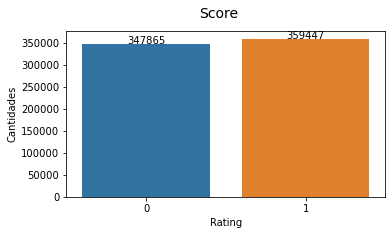

In [86]:
#observamos la distribución de las calificaciones
fig, axes = plt.subplots(1,1, figsize=(5, 3))
fig.suptitle('Score', fontsize=14)
fig.tight_layout(pad=0.50)
sns.countplot(x='score',data=df)
axes.set_xlabel("Rating")
axes.set_ylabel("Cantidades")

for rect in axes.patches:
    axes.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 10)

#plt.grid()
plt.show()

Se observa el rating asignado, 0 es para calificaciones negativas (49.2%) y 1 para las positivas (50.8%), se encuentra balanceado entre las clasificaciones de los usuarios a los juegos que consumieron.

#### d.6 Encode: Obtención rectangulo de datos <a class="anchor" id="section_1_4_6"></a>
[Tabla de contenidos](#TOC)

Encodeamos el nombre del juego así tener una variable numerica y con números consecutivos. También encodeamos el nombre de usuario ya que los ID proporcionados la mayoria de los datos son nulos, con lo cual al cargar el dataset se descartó esa columna para luego crear un identificador manualmente. Esto lo hacemos para poder ordenar la feature de usuarios de forma ascendente o descendente para luego poder filtrar, así tomar una muestra más pequeña y probar que todo corra corectamente antes de migrar al escenario de big data.

Hacer un rectangulo, tomar esos datos y pasarlos al modelo. Usar label encoder para encodear los nombres de los usuarios y también el product id, así tener una variable numérica continua y poder filtrar con where y obtener el rectángulo.

Nota: este proceso solo lo hacemos para trabajar con small-data, así poder correr todo el código y luego pasarnos a big-data

In [36]:
#Cargamos dataset
df1 = pd.read_csv('data/df_ratings.csv')

In [40]:
df = df1[['product_id','username','app_name','score']]
df.head()

,product_id,username,app_name,score
0,328100,dll3z,Gunspell - Steam Edition,0
1,328100,Nyazicat,Gunspell - Steam Edition,0
2,328100,novocain,Gunspell - Steam Edition,1
3,328100,raixel,Gunspell - Steam Edition,1
4,328100,Shwgar,Gunspell - Steam Edition,0


In [41]:
#Verificamos los tipos de datos 
df.dtypes

product_id     int64
username      object
app_name      object
score          int64
dtype: object

LabelEncoder

In [42]:
# Categorical boolean mask
categorical_feature_mask = df.dtypes==object

In [43]:
# filter categorical columns using mask and turn it into a list
categorical_cols = df.columns[categorical_feature_mask].tolist()
categorical_cols

['username', 'app_name']

In [44]:
# LabelEncoder converts each class under specified feature to a numerical value. Let’s go through the steps to see how to do it.
#Instantiate a LabelEncoder object:
# import labelencoder
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()

In [45]:
df = df.copy()
#Apply LabelEncoder on each of the categorical columns:
# apply le on categorical feature columns
df[categorical_cols] = df[categorical_cols].apply(lambda col: le.fit_transform(col))

In [46]:
df = df[categorical_cols]
#hacer rename columnas
df.rename(columns={'username': 'user_num', 'app_name': 'app_num'}, inplace=True)

La salida del LabelEncoder aún es un Dataframe. A continuación el resultado:

In [47]:
df.head()

,user_num,app_num
0,390724,3737
1,227307,3737
2,436133,3737
3,444114,3737
4,281618,3737


Concatenamos así agregamos los valores reales

In [48]:
result = pd.concat([df, df1], axis=1, join="inner")

In [49]:
result.head()

,user_num,app_num,product_id,username,app_name,price,hours,score
0,390724,3737,328100,dll3z,Gunspell - Steam Edition,14.99,0.4,0
1,227307,3737,328100,Nyazicat,Gunspell - Steam Edition,14.99,2.2,0
2,436133,3737,328100,novocain,Gunspell - Steam Edition,14.99,3.8,1
3,444114,3737,328100,raixel,Gunspell - Steam Edition,14.99,3.2,1
4,281618,3737,328100,Shwgar,Gunspell - Steam Edition,14.99,1.4,0


In [50]:
result = result[['user_num','app_num','score']]
result.head(5)

,user_num,app_num,score
0,390724,3737,0
1,227307,3737,0
2,436133,3737,1
3,444114,3737,1
4,281618,3737,0


Ordenamos el datast por usuario y juego

In [51]:
result = result.copy()
result.sort_values(['user_num', 'app_num'], ascending=[True, True], inplace=True)
#result.sort_values(['user_num'], ascending=True, inplace=True)

result.head()

,user_num,app_num,score
632914,0,6960,0
320563,1,643,0
416272,1,9202,0
629177,2,1229,1
576688,3,3665,0


In [52]:
result.shape

(707312, 3)

In [53]:
result.user_num.nunique()

494797

In [54]:
result.user_num.isnull().sum()

0

In [55]:
result.app_num.isnull().sum()

0

In [56]:
result.dtypes

user_num    int64
app_num     int64
score       int64
dtype: object

In [57]:
# Cantidad de usuarios cuyo id sea menor a 1000, se observará que el valor es mayoy a 1000 porque hay usuarios que han calificado más de un juego
(result['user_num'] < 1000).sum()

1281

In [58]:
#Aquí verificamos que los usuarios únicos sean igual a 1000
result[result['user_num'] < 1000].nunique()

user_num    1000
app_num      674
score          2
dtype: int64

In [59]:
#(result['app_num'] < 1000).sum()

Creamos filtro para obtener un rectágulo de la matriz, así tener de los usuarios seleccionados todas sus clasificaciones.

In [60]:
## Mascaras/Filtros
filter1 = result['user_num'] < 10000
filter2 = result['app_num'] < 1000

In [61]:
# Filtramos la data a partir de los dos filtros anteriores
dfx =  result.where(filter1 & filter2, inplace = False)

In [62]:
dfx.dropna(inplace=True)
dfx.reset_index(drop=True, inplace=True)

In [63]:
dfx

,user_num,app_num,score
0,1.0,643.0,0.0
1,8.0,639.0,0.0
2,39.0,471.0,0.0
3,51.0,221.0,1.0
4,59.0,454.0,1.0
...,...,...,...
1234,9954.0,358.0,0.0
1235,9969.0,504.0,1.0
1236,9977.0,883.0,1.0
1237,9985.0,392.0,0.0


Guardamos en un csv, el rectángulo.

In [64]:
dfx.to_csv('data/df_rating_encoded_rectangulo_1.csv', index= False)

Graficamos la cantidad de calificaciones por usuario

In [69]:
#data = dfx.groupby('user_num')['app_num'].count().clip(upper=5)
#data.hist()
#plt.show()

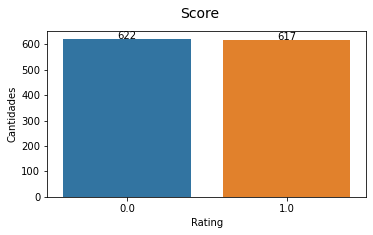

In [87]:
#observamos la distribución de las calificaciones
fig, axes = plt.subplots(1,1, figsize=(5, 3))
fig.suptitle('Score', fontsize=14)
fig.tight_layout(pad=0.50)
sns.countplot(x='score',data=dfx)
axes.set_xlabel("Rating")
axes.set_ylabel("Cantidades")

for rect in axes.patches:
    axes.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 10)

#plt.grid()
plt.show()

Las calificaciones para el conjunto de datos elegidos se encuentran balanceadas.

### e. Gráficos interpretación y entendimiento de datos<a class="anchor" id="section_1_5"></a> 
[Tabla de contenidos](#TOC)

#### e.1 Graficamos la distribución de las horas según el juego - Top 20<a class="anchor" id="section_1_5_1"></a> 
[Tabla de contenidos](#TOC)

In [105]:
# Mask criteria for box plot.
#mask_criteria = df1[col_game].isin(df_top_hours_played['game_name'])
df_box_plot = df_sin_outliers[['hours', 'app_name']]

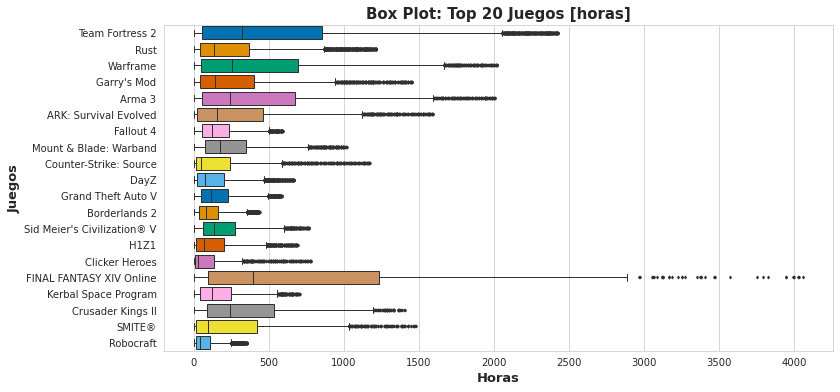

In [106]:
# Creación de box-plot.
nb_games = 20
fig_h = 1 + 0.25 * max(1, nb_games)
fig, ax = plt.subplots(figsize=(12, fig_h))
sns.set_style("whitegrid")
ax = sns.boxplot(x='hours', y='app_name', data=df_box_plot,
                 order=df_top_hours_played['app_name'].to_list(),
                 palette="colorblind",
                 saturation=1,
                 linewidth=1,
                 fliersize=2)
plt.title('Box Plot: Top {} Juegos [horas]'.format(nb_games),fontsize=15, fontweight='heavy')
plt.xlabel('Horas', fontsize=13, fontweight='demi')
plt.ylabel('Juegos', fontsize=13, fontweight='demi')
plt.show()

El segmento que divide la caja en dos partes es la mediana, de allí se observa que la distribución presenta una asimetría positiva o segada a la derecha, la parte más larga de la caja es la parte superior a la mediana. Los datos se concentran en la parte inferior de la distribución. La media suele ser mayor que la mediana.  Esto no quiere decir que ese lado contenga más datos. Indica un rango más amplio, por lo que los datos estarán mas dispersos. Un rango menos amplio, indica que los datos están más próximos.

#### e.2 Graficamos la cantidad de usuarios agrupados en bins según en precio<a class="anchor" id="section_1_5_2"></a> 
[Tabla de contenidos](#TOC)

In [107]:
data = df_sin_outliers

In [108]:
data2 = df_sin_outliers.groupby(['product_id'], as_index=False)['price'].count().sort_values(['price'], ascending=False)

In [109]:
data2

,product_id,price
19,440,17317
2035,252490,9244
860,49520,6760
5364,377160,6554
2492,271590,5545
...,...,...
2215,260410,0
4528,349580,0
5818,394740,0
2236,261570,0


In [110]:
intervalos = range(min(data2.price.values), max(data2.price.values) + 2) #calculamos los extremos de los intervalos
intervalos

range(0, 17319)

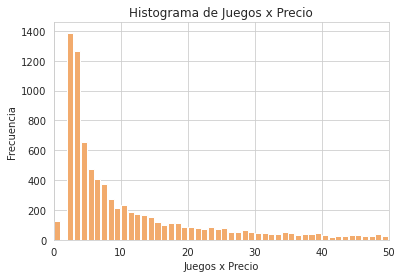

In [111]:
# Graficamos la cantidad de usuarios agrupados en bins según en precio
plt.hist(x=data2.price.values, bins=intervalos, color='#F2AB6D', rwidth=0.90)
plt.title('Histograma de Juegos x Precio')
plt.xlim([0, 50])
plt.xlabel('Juegos x Precio')
plt.ylabel('Frecuencia')
#plot.xticks(intervalos)
#for rect in axes[0].patches:
#    axes[0].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)
plt.show()

##### e.3 Distribucion de los precios de los juegos<a class="anchor" id="section_1_5_3"></a>
[Tabla de contenidos](#TOC)

In [72]:
#df['price'] = df['price'].astype('int')
##data_games['id'] = data_games['id'].astype('int')
#df['price'] 
data[data["price"] == "0"].price.count()

0

In [114]:
# Obtenemos los valores que toma la variable price
data['price'].unique()

array(['14.99', '9.99', '19.99', '4.99', nan, '5.99', '11.99', '3.99',
       'Free to Play', '29.99', '2.99', '1.99', '0.99', '18.99', '39.99',
       '7.99', '13.99', '6.99', 'Free To Play', 'Free', '20.0', '59.99',
       '12.99', '15.99', '24.99', 'Play for Free!', '1.87', '16.99',
       '8.99', '17.99', '44.99', '5.65', '49.99', '34.99', '0.5', '0.89',
       '119.99', '0.49', '10.99', '10.96', '79.99', '189.96', '74.99',
       '15.0', '2.97', '4.0', '11.15', 'Play WARMACHINE: Tactics Demo',
       '4.68', '12.89', 'Play the Demo', '54.99', '31.99', '49.0',
       '13.98', '44.98', '74.76', '32.99', '4.49', '189.0', '0.98',
       '202.76', '61.99', '13.37', '3.0', '69.99', 'Free to Use', '87.94',
       '99.99', 'Install Now', '7.49', '16.06', '3.49', '19.98', '3.33',
       '23.96', 'Free Mod', '21.99', '6.66', '64.99', '19.95', '2.49',
       '139.92', '199.0', '23.99', '12.0', '1.0', '9.95', 'Third-party',
       '2.0', '160.91', '20.99', '10.0', '299.99', '26.99', 'Free Mov

In [115]:
#Creamos listas para Imputar los valoeres categoricos por numericos
lista_free = ['Free to Play','Free To Play', 'Free','Play for Free!','Play WARMACHINE: Tactics Demo','Play the Demo','Free Mod','Free to Use','Install Now','Free to Try','Third-party','Free Movie', 'Free HITMAN™ Holiday Pack']
lista_cost = ['Starting at $449.00']

In [116]:
##df.reset_index(inplace=True)
#df2 = df.loc[df['price'].isin(lista_free)]
#df2.shape
##df['price'] = df.loc[df['price'].isin(lista_free)]

Convertimos los valores que machean en la lista lista_free en 0

In [117]:
#df.loc[df['price'] == lista_free, 'price'] = '0'
#df.reset_index(inplace=True)
data.loc[data["price"].isin(lista_free), "price"] = "0"
data[data["price"] == "0"].price.count()

131689

Seteamos el valor de price en el valor míninmo 449 del precio de jueo para los que están en la lista_cost

In [118]:
#df.loc[df['price'] == lista_cost, 'price'] = '449'
data.loc[data["price"].isin(lista_cost), "price"] = "449"

In [119]:
#data[data.price.isnull()].value_counts()
data.app_name[data.price.isnull()].value_counts()

Ori and the Blind Forest           1021
Tactical Intervention               561
America's Army: Proving Grounds     394
Serena                              386
Romero's Aftermath                  364
                                   ... 
Monuments of Mars                     2
Basketball Pro Management 2014        2
Pilot Crusader                        2
Zen Fish SIM                          2
Heroes of Arca                        2
Name: app_name, Length: 124, dtype: int64

In [120]:
## Hay 6047 revies con precio NaN, hacemos un fillna y rellenamos con precio 0
#data.price.fillna(0, inplace=True)
data.dropna(subset=['price'], inplace=True)

In [121]:
data.price.isnull().sum()

0

In [122]:
#Convierto price de object to int

#df.reset_index(drop=True,inplace=True)
data = data.copy()
data['price'] = data['price'].astype('float').astype('int')

In [123]:
data['price'].unique()

array([ 14,   9,  19,   4,   5,  11,   3,   0,  29,   2,   1,  18,  39,
         7,  13,   6,  20,  59,  12,  15,  24,  16,   8,  17,  44,  49,
        34, 119,  10,  79, 189,  74,  54,  31,  32, 202,  61,  69,  87,
        99,  23,  21,  64, 139, 199, 160, 299,  26, 771])

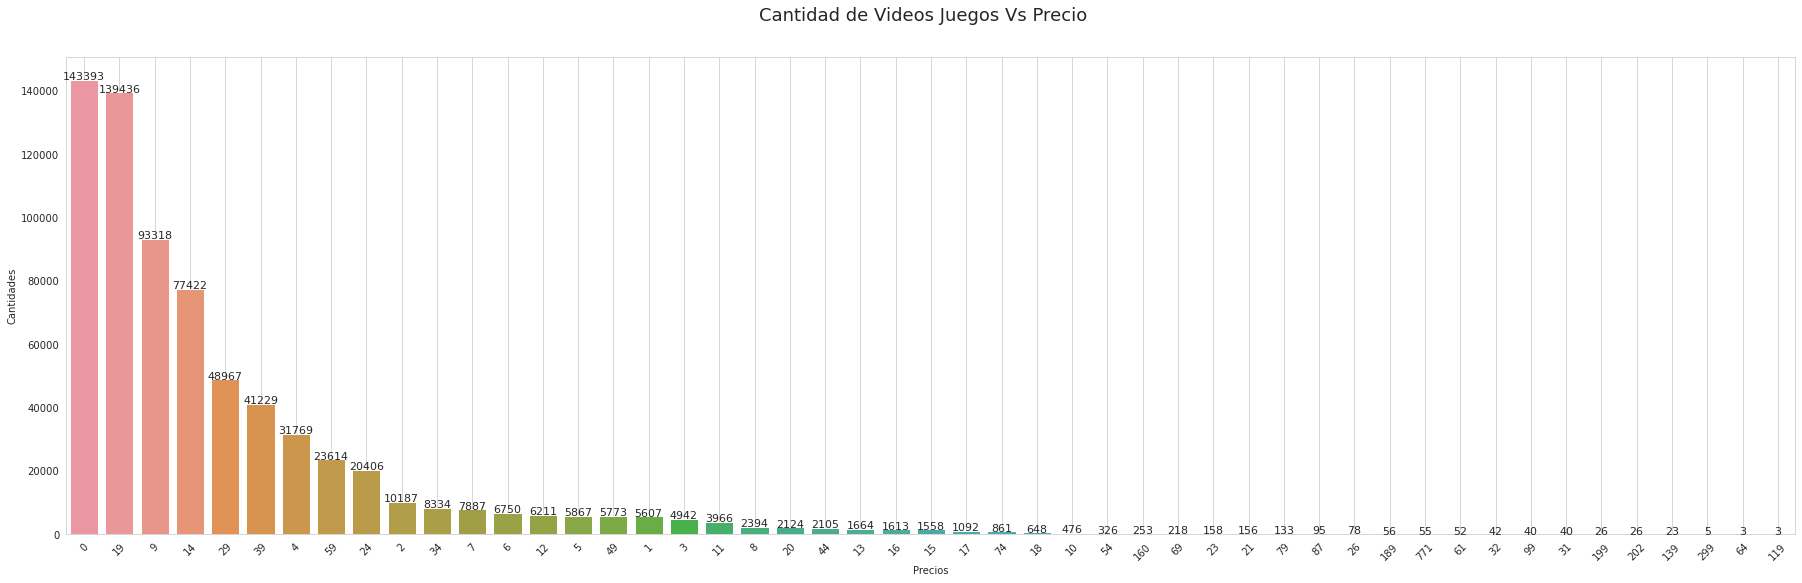

In [124]:
#### Distribucion de los precios de los juegos
## creamos la figura con subplots de 1 linea 2 columnas
fig, axes = plt.subplots(1,1, figsize=(25, 8))
fig.suptitle('Cantidad de Videos Juegos Vs Precio', fontsize=18)
#padding between subplots. Pass a float parameter to specify the amount of padding between subplots.
fig.tight_layout(pad=2.0)

# GRacount 0
sns.countplot(data = data, x = "price", orient='v', order = data['price'].value_counts().index)
#axes.set_title("Todas los tipos: ",fontsize = 10, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
#plt.sca(axes[0, 1])
#plt.sca(axes[0])
plt.xticks(rotation=45)
axes.set_xlabel("Precios")
axes.set_ylabel("Cantidades")
plt.grid()

for rect in axes.patches:
    axes.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

#Grafico 1
#sns.countplot(data = df, x = "pr", orient='v', ax=axes[1], order = df['property_type_2'].value_counts().index)
#axes[1].set_title("Agrupados: ",fontsize = 10, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
#plt.sca(axes[1])
#plt.xticks(rotation=45)
#plt.grid()

#for rect in axes[1].patches:
#    axes[1].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

Se observa que el 78% de los juegos comprados tienen un valor menor a 19 dolares y un 23% de los juegos adquiridos son gratuitos.

#### e.4 Cantidad de videos Juegos por usuarios<a class="anchor" id="section_1_5_4"></a>
[Tabla de contenidos](#TOC)

In [125]:
# Cargamos el Dataset
df = pd.read_csv('data/df_out_sin_outliers.csv')

In [126]:
#Seleccionamos las features con tentativa de uso
df1 = df[['product_id','username','app_name','price','hours']]

In [129]:
# Obtenemos por usuarios la cantidad de productos adquiridos
Pop_rec = df1.groupby(['username'], as_index=False)['product_id'].count()

In [130]:
#Renombramos los nombres de las columnas
Pop_rec.rename(columns={'product_id': 'cnt_juegosxusuarios'}, inplace=True)
#data2.head(20).sort_values(['cnt_juegosxusuarios'], ascending=False).head(10)
Pop_rec.head(10)

,username,cnt_juegosxusuarios
0,!,1
1,! ZerZ,2
2,! ! ŦŕĩŽǿЯëќ™ ! !,1
3,! Alga,2
4,! DeadlyDeal !,1
5,! Dr Feelgood,1
6,! EREN,1
7,! Monika !,2
8,! Taz the Husky,4
9,! ToxicWizzard,1


In [131]:
Pop_rec.sort_values(['cnt_juegosxusuarios'], ascending=False).describe()

,cnt_juegosxusuarios
count,494795.000000
mean,1.429491
std,1.832017
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,162.000000


Vemos la distribución de la cantidad de usuarios por juego, teniendo una media de 1.44, un mínimo de 1 juego y un máximo de 213. Tambíen se observa que el 75% de los usuarios tiene 1 juego.

In [135]:
Pop_rec_sort = Pop_rec.sort_values(['cnt_juegosxusuarios'], ascending=False)
Pop_rec_sort.describe()

,cnt_juegosxusuarios
count,494795.000000
mean,1.429491
std,1.832017
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,162.000000


Ahora analizamos la características estadísticas de los top 100:

In [136]:
data_top = Pop_rec.sort_values(['cnt_juegosxusuarios'], ascending=False).head(100)

In [137]:
data_top.describe()

,cnt_juegosxusuarios
count,100.000000
mean,70.370000
std,24.457613
min,47.000000
25%,52.750000
50%,64.000000
75%,81.250000
max,162.000000


#### A continuación analizamos los 10000 usuarios que más juegos tienen y la cantidad de juegos por usurios sobre todo el conjunto de datos

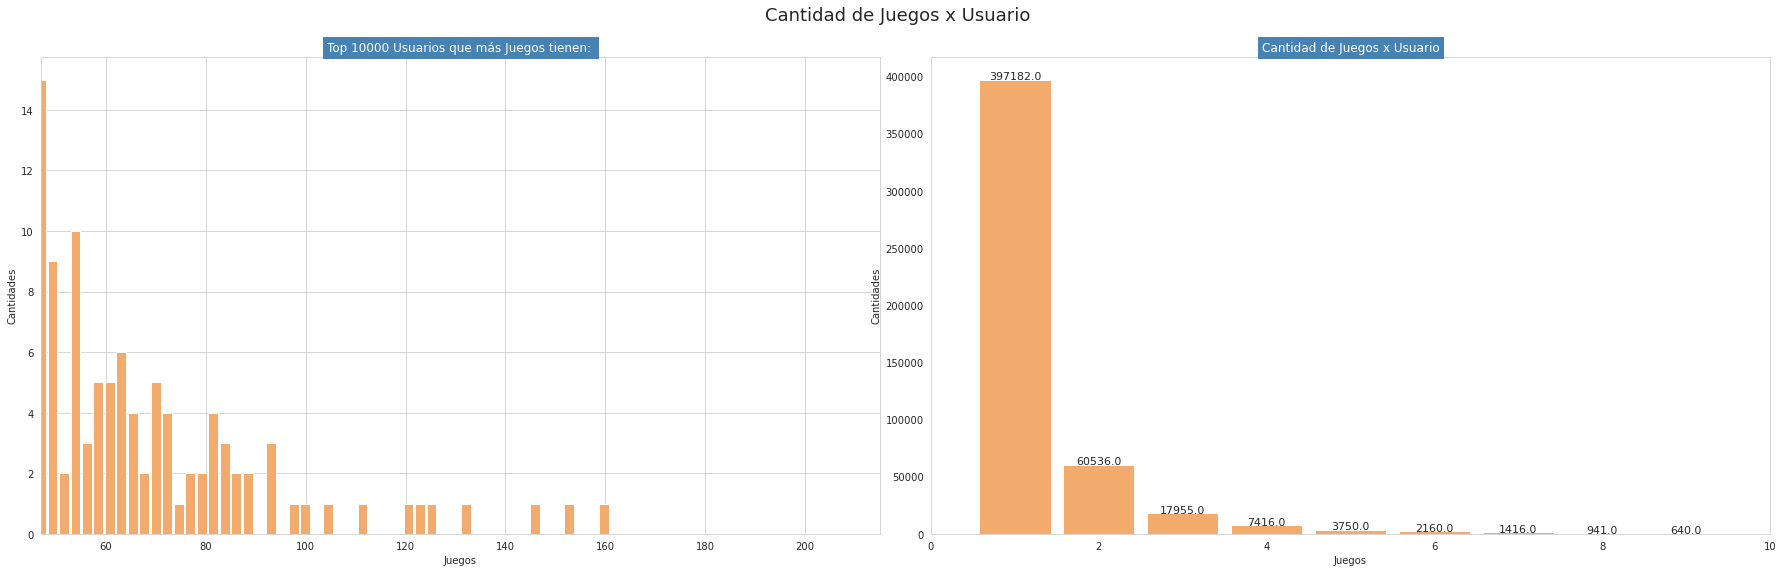

In [138]:
intervalos = range(min(Pop_rec_sort.cnt_juegosxusuarios), max(Pop_rec_sort.cnt_juegosxusuarios) + 2) #calculamos los extremos de los intervalos

## creamos la figura con subplots de 1 linea 2 columnas
fig, axes = plt.subplots(1,2, figsize=(25, 8))
fig.suptitle('Cantidad de Juegos x Usuario', fontsize=18)
#padding between subplots. Pass a float parameter to specify the amount of padding between subplots.
fig.tight_layout(pad=2.0)
plt.grid()

# Grafico 0
#sns.countplot(data = df, x = "price", orient='v', order = df['price'].value_counts().index)
axes[0].set_title("Top 10000 Usuarios que más Juegos tienen: ",fontsize = 12, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
axes[0].hist(x=data_top.cnt_juegosxusuarios, bins=50, color='#F2AB6D', rwidth=0.85, align='left')
#axes.set_title("Todas los tipos: ",fontsize = 10, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
#plt.sca(axes[0, 1])
#plt.sca(axes[0])
plt.xticks(rotation=45)
axes[0].set_xlabel("Juegos")
axes[0].set_ylabel("Cantidades")
axes[0].set_xlim([47,215]) ## limite en x, para acotar y quitar los outliers

#count=0
#for rect in axes[0].patches:
#    count +=1
#    if count < 12:  
#        # prints the quit message
#        #print(quit)
#        axes[0].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)


#Grafico 1

axes[1].set_title("Cantidad de Juegos x Usuario",fontsize = 12, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
axes[1].hist(x=Pop_rec_sort.cnt_juegosxusuarios, bins=intervalos, color='#F2AB6D', rwidth=0.85, align='left')
#plt.sca(axes[0, 1])
#plt.sca(axes[0])
plt.xticks(rotation=0)
axes[1].set_xlabel("Juegos")
axes[1].set_ylabel("Cantidades")
axes[1].set_xlim([0,10]) ## limite en x, para acotar y quitar los outliers

count=0
for rect in axes[1].patches:
    count +=1
    if count < 10:  
        axes[1].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

plt.show()

En el gráfico de la izaquieda observamos el top 10000 de los usuarios que han comprado más juego y su distribución. Se observa que el 67.8% ha comprado 5 juegos, y 1.5% ha comprada 10 juegos. El gráfico de la derecha se grafica todos los datos, el 55% de los usuarios ha comprado 1 Juego, el 8.5% 2 Juegos y el 1% 3 Juegos.

#### e.5 El Juego más comprado es el más Jugado?<a class="anchor" id="section_1_5_5"></a>
[Tabla de contenidos](#TOC)

Vamos a determisnar si el juego más comprado se corresponde con el más jugado. Por cada juego, vamos a computar el total de usuarios y el total de tiempo por juego por todos los usuarios. El resultado lo mostraremos a continuacion, solo mostraremos el top 20 de los juegos con más horas/usuarios.

Usamos un Histograma para visualizar el resultado de la tabla de abajo. Los Juegos están ordenados de forma decreciente basado en el número de usuarios. El color del gradiente representa el total de horas jugadas.

Podemos usar la tabla de abajo para comparar con el Histograma si se mantiene el order y la lógica, juego más jugado es el que tiene más usuarios. Para verlo más claro y en un mismo gráfico se hace el histograma que contempla las dos variables, eje x la cantidad de usuarios y el color del gradiente es según la cantidad de horas jugadas.

In [139]:
# Top de juegos más jugados según el número de horas
top = 20
game_total_hrs = df1.groupby(by='app_name')['hours'].sum()
most_played_games = game_total_hrs.sort_values(ascending=False)[:top]
most_played_games.head(20)

app_name
Team Fortress 2                     9384320.8
Rust                                2354540.7
Warframe                            2290502.1
Arma 3                              1635550.7
Garry's Mod                         1214971.9
ARK: Survival Evolved               1185788.6
Fallout 4                           1027882.9
Grand Theft Auto V                   855617.3
Mount & Blade: Warband               827120.3
Borderlands 2                        756150.4
DayZ                                 680989.3
Sid Meier's Civilization® V          662635.2
Crusader Kings II                    584648.2
Kerbal Space Program                 530220.6
H1Z1                                 530210.3
FINAL FANTASY XIV Online             517805.3
SMITE®                               481046.8
Tom Clancy's Rainbow Six® Siege      457344.0
Counter-Strike: Source               449981.0
Counter-Strike: Global Offensive     447260.1
Name: hours, dtype: float64

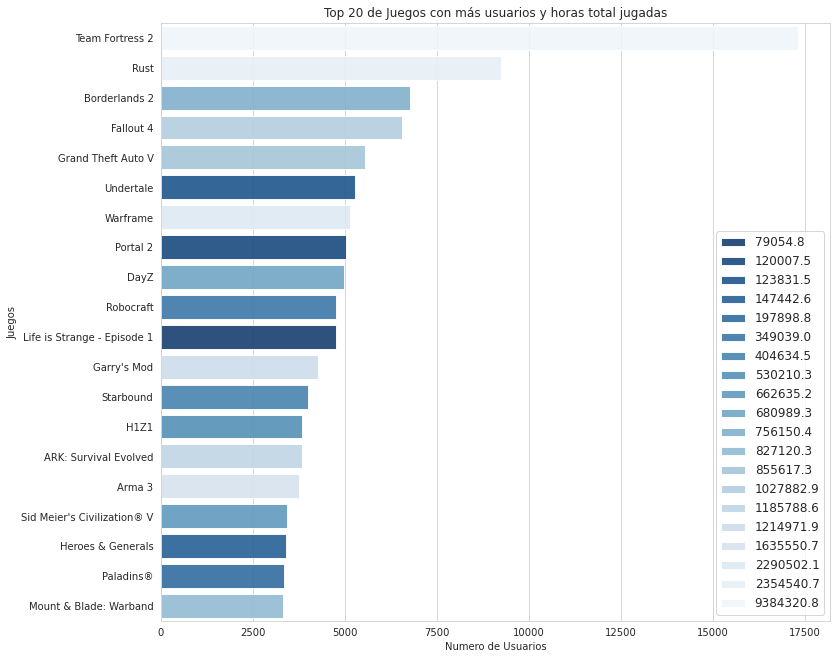

In [140]:
# Juegos con mayor número de usuarios vs horas jugadas
game_freq = df1.groupby(by='app_name').agg({'username': 'count', 'hours': 'sum'}).reset_index()
top20 = game_freq.sort_values(by='username',ascending=False)[:20].reset_index()
#print(top20)
top20['hours']=top20['hours'].round(1)
# histogram
fig_h = 1 + 0.25 * max(1, 2*top)
fig, ax = plt.subplots(figsize=(12, fig_h))

#fig, ax = plt.figure(figsize=(20, 10))
#sns.set(font_scale = 2)
ax = sns.barplot(x='username', y='app_name', hue='hours',alpha=0.9,data=top20, palette='Blues_r',dodge=False)
ax.set(xlabel='Numero de Usuarios', ylabel='Juegos', title="Top {} de Juegos con más usuarios y horas total jugadas".format(top))
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend(fontsize=12)
plt.show()

Se observa que no se guarda la relación supuesta, el color del gradiente  no es un degradé continua según el orden de los juegos por usuarios. Por ejemplo,  el "bordelands 2" está en el top3 según el número de usuarios, pero está en el puesto número 12 según la cantidad de horas jugadas total. A continuación vamos analizar solamente los que fueron jugados, suponemos que los que tienen una duración mayor de 1 hora fueron jugados y los que no, solamente comprados.

In [141]:
# Los comprados que consideramos que no se han jugado, tiempo menor o = a 1 hora
print("Cantidad de juegos comprados {} - Los comprados que consideramos que no se han jugado, tiempo menor o = a 1 hora: {} ({:.2f}%)".format(df1.shape[0], df1[df1['hours']<=1].shape[0], float((df1[df1['hours']<=1].shape[0])/df1.shape[0]*100)   ))

Cantidad de juegos comprados 707305 - Los comprados que consideramos que no se han jugado, tiempo menor o = a 1 hora: 78411 (11.09%)


In [142]:
# Los comprados y jugados, cuyo tiempo es mayor a una hora.
print("Cantidad de juegos comprados {} - Los comprados que consideramos que se han jugado, tiempo menor o = a 1 hora: {} ({:.2f}%)".format(df1.shape[0], df1[df1['hours']<=1].shape[0], float((df1[df1['hours']>=1].shape[0])/df1.shape[0]*100)   ))

Cantidad de juegos comprados 707305 - Los comprados que consideramos que se han jugado, tiempo menor o = a 1 hora: 78411 (89.72%)


Se observa que el 10,63% de los juegos solamente fueron adquiridos y no jugados tomando como criterio si las horas de juego es menor a 1.

Text(0, 0.5, 'Usuarios')

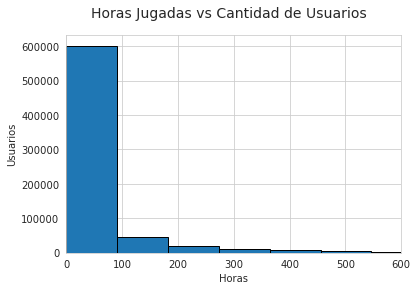

In [153]:
##Distribucion
plt.suptitle('Horas Jugadas vs Cantidad de Usuarios', size = 14);
plt.hist(df1['hours'], bins=100, alpha=1, edgecolor = 'black',  linewidth=1)
plt.xlim([0,600]) ## limite en x, para acotar y quitar los outliers
plt.xlabel("Horas")
plt.ylabel("Usuarios")

En el histograma anterior se observa la distribucion de las horas jugadas de todos los juegos y usuarios, observando una concentración de horas menor a 250.

#### e.6 Graficamos solamente a los que fueron jugados<a class="anchor" id="section_1_5_6"></a>
[Tabla de contenidos](#TOC)

Quitamos los que suponemos que no fueron jugados para ver si cambia la relación

In [154]:
#df1 = df1.copy()
#index=df1[df1['hours']==0].index
#df1.drop(index,inplace=True)
#game_total_hrs = df1.groupby(by='app_name')['hours'].sum()
#most_played_games = game_total_hrs.sort_values(ascending=False)[:20]

<ipython-input-155-edf004e13da9>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticklabels(), rotation=0, fontsize=10)


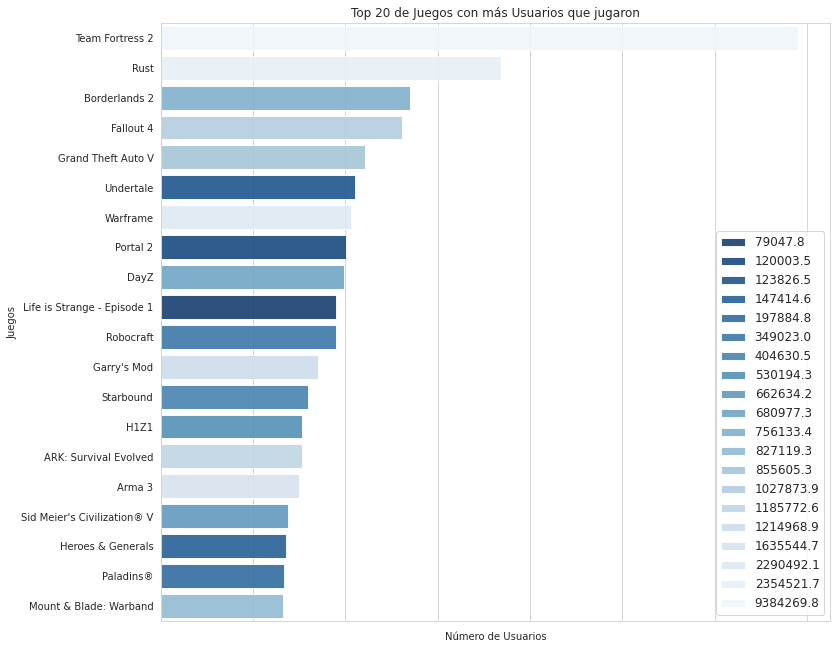

In [155]:
#Consideramos solo a los que han jugado por lo menos 1 hora
df1=df1.copy()
index=df1[df1['hours']==1].index
df1.drop(index,inplace=True)
game_total_hrs = df1.groupby(by='app_name')['hours'].sum()
most_played_games = game_total_hrs.sort_values(ascending=False)[:20]
# Juegos con el mayor número de usuarios
game_freq = df1.groupby(by='app_name').agg({'username': 'count', 'hours': 'sum'}).reset_index()
top20 = game_freq.sort_values(by='username',ascending=False)[:20].reset_index()
top20['hours']=top20['hours'].round(1)

fig_h = 1 + 0.25 * max(1, 2*top)
fig, axes = plt.subplots(figsize=(12, fig_h))

#plt.figure(figsize=(20, 8))
#axes = sns.set(font_scale = 2)
axes = sns.barplot(x='username', y='app_name', hue='hours',alpha=0.9,data=top20, palette='Blues_r',dodge=False)
axes.set(xlabel='Número de Usuarios', ylabel='Juegos', title='Top {} de Juegos con más Usuarios que jugaron'.format(top))
#axes.set_xticklabels(ax.get_xticklabels(), rotation=90)
axes.set_xticklabels(axes.get_xticklabels(), rotation=0, fontsize=10)
axes.set_yticklabels(axes.get_yticklabels(), rotation=0, fontsize=10)
axes.xaxis.set_tick_params(labelsize=14)
axes.legend(fontsize=12)
plt.show()

No se observan cambios en el top 5 con respecto a la gráfica anterior

In [156]:
print("Cantidad de Juegos {} y Cantidad de Usuarios {}".format(df1.app_name.nunique(),df1.username.nunique()))

Cantidad de Juegos 9887 y Cantidad de Usuarios 491789


### Modelo Machine Learning <a class="anchor" id="chapter2"></a>

#### f. Desarrollo del Modelo <a class="anchor" id="section_2_1"></a>
[Tabla de contenidos](#TOC)

A continuación se creará un modelo para recomendar juegos a los usuarios dentro de la plataforma STEAM empleando la librería `surprise`.

#### f.1 Filtro Coloborativo (con Surprise) <a class="anchor" id="section_2_1_1"></a>
[Tabla de contenidos](#TOC)

A los usuarios se le recomiendan artículos que a personas con gustos y preferencias similares les gustaban en el pasado. En otras palabras, este método predice calificaciones desconocidas utilizando las similitudes entre los usuarios. Se basa en el supuesto que si a las personas están de acuerdo en el pasado lo estarán en el futuro (dado que a personas con tus mismos gustos le gusta X, a ti también te gustará). La desventaja de esté método rige que sin un ranking inicial, no hay recomendación.

#### f.2 Metrica  <a class="anchor" id="section_2_1_2"></a>
[Tabla de contenidos](#TOC)

Usaremos la libreria `Surprise`  y  probaremos varios algoritmos para ver cual es que obtiene un menor RMSE (Root Mean Absolute Error) y si vale la pena por tiempo de computo ya que estamos trabajando con Big Data. Recordar que el rating es una variable binario (0,1)


#### f.3 Algoritmos <a class="anchor" id="section_2_1_3"></a>
[Tabla de contenidos](#TOC)

Con la biblioteca `Surprise`, compararemos los siguientes algoritmos: <br>

**Algoritmos básicos** <br>

`NormalPredictor` El algoritmo NormalPredictor predice una clasificación aleatoria basada en la distribución del conjunto de entrenamiento, que se supone que es normal. Este es uno de los algoritmos más básicos que no hace mucho trabajo. <br>
`BaselineOnly`
El algoritmo BaselineOnly predice la estimación de baseline para un usuario y elemento determinados.


**algoritmos k-NN**

`KNNBasic` : KNNBasic es un algoritmo de filtrado colaborativo básico. <br>
`KNNWithMeans`: KNNWithMeans es un algoritmo de filtrado colaborativo básico, teniendo en cuenta las valoraciones medias de cada usuario. <br>
`KNNWithZScore`: KNNWithZScore es un algoritmo de filtrado colaborativo básico que tiene en cuenta la normalización del z-score de cada usuario. <br>
`KNNBaseline`: KNNBaseline es un algoritmo de filtrado colaborativo básico que tiene en cuenta una calificación de referencia. <br>

**Algoritmos basados en la factorización de matrices**

`SVD` : El algoritmo SVD es equivalente a la factorización matricial probabilística <br>
`SVDpp`: El algoritmo SVDpp es una extensión de SVD que tiene en cuenta las calificaciones implícitas. <br>
`NMF`: NMF es un algoritmo de filtrado colaborativo basado en factorización matricial no negativa. Es muy similar con SVD. <br>
`Slope One`: SlopeOne es una implementación sencilla del algoritmo SlopeOne. <br>
`Co-clustering`:  Coclustering es un algoritmo de filtrado colaborativo basado en co-clustering. <br>

Usamos "RMSE" como nuestra métrica de precisión para las predicciones, que es la métrica utilizada por la mayoría en los filtros coloborativos.

#### f.4 Manos a la obra con Surprice <a class="anchor" id="section_2_1_4"></a>
[Tabla de contenidos](#TOC)

Primero se probó con una pequeña matriz o rectangulo, en donde tenemos todos los datos de un usuario en particular, es decir del usuario 1 tenemos todas la calificaciones. Para obtener esa matriz, se tuvo que encodear los nombres de usuarios para poder ordenarlos y tener todas las calificaciones de los usuarios seleccionados.  Esto lo usuamos para reducir tiempo de procesamiento y validar nuestro modelo.

Luego una vez validado el modelo con los datos anteriores pasamos a utilizar el dataset total, a este le hacemos el train test split y luego aplicamos la predicciones.

In [4]:
## Importamos lo necesario 
### Surprice
## conda install -c conda-forge scikit-surprise

import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse, mae
from surprise import accuracy
from surprise.model_selection import train_test_split

Surprise necesita un conjunto de datos, con tres variables: identificación de usuario, identificación del artículo y calificación. Esto es importante, no hay que pasar las calificaciones en un formato de matriz de calificaciones de elementos de usuario. El dataset tiene 3 columnas y el número de filas es igual al número total de calificaciones individuales. A continuación cargamos el dataset (user_num, app_num, score):

In [5]:
## Cargamos el dataset con un rectágulo de los datos (Small Data)
#ratings = pd.read_csv('data/trainUsers.csv')
ratings = pd.read_csv('data/df_rating_encoded_rectangulo_1.csv')
ratings.head()

,user_num,app_num,score
0,1.0,643.0,0.0
1,8.0,639.0,0.0
2,39.0,471.0,0.0
3,51.0,221.0,1.0
4,59.0,454.0,1.0


Se crea el objeto Reader, con los siguientes atributos:
- line_format: asegurar que el orden corresponda con el del dataset
- sep: es coma, si estamos trabajando con csv
- rating_scale: is una tuple con el menor y mayor rango posible. Es importante establecer correctamente este parámetro, porque en caso contrario cierta data puede ser ignorada. Si usamos un score binario, el valor correcto es la tupla (0,1)

In [6]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 1))

De esta forma, se define el objeto `Reader` para que Surprise pueda parsear el archivo o el dataframe. Para cargar un conjunto de datos desde un archivo (por ejemplo, un archivo csv), necesita el método `load_from_file()`. Para cargar un conjunto de datos desde un Dataframe de pandas, necesitará el método `load_from_df()`. También es necesario el objeto Reader, pero solo se debe especificar el parámetro rating_scale. El Dataframe debe tener tres columnas, correspondientes a los ID de usuario (sin procesar), los ID de elemento (sin procesar) y las calificaciones,  en este orden. Por lo tanto, cada fila corresponde a una calificación determinada. Esto no es restrictivo, ya que puede reordenar las columnas del Dataframe fácilmente.

Para importar la data, usamos el método `load_form_file`, luego de esto ya tenemos el dataset en formato `surprise` 

In [7]:
ratings = ratings[['user_num','app_num','score']]
#ratings = ratings[['username','app_name','score']]
data = Dataset.load_from_df(ratings, reader)
#data.split(n_folds=5)

De la clase `model_selection` importamos el método `train_test_split`. Dividimos la data en `trainset` y `testset`, `test_size` está seteado al 20%. Una vez más, es un poco diferente de cómo funcionaría un modelo de clasificador / regresión, el conjunto de pruebas contiene calificaciones de usuarios/elementos seleccionados al azar, en lugar de usuarios / elementos completos. Un usuario puede tener 10 calificaciones en los datos, y 3 de ellas ahora se seleccionan al azar para el conjunto de pruebas, no para ser utilizadas para ajustar el modelo. Tiene mucho sentido no omitir por completo a ciertos usuarios.

In [8]:
trainset, testset = train_test_split(data, test_size=0.2)

El segundo enfoque es utilizar los datos completos y realizar una validación cruzada para las pruebas. En ese caso, podemos construir un objeto Trainset usando todas las calificaciones con el método build_full_trainset:

In [9]:
trainsetfull = data.build_full_trainset()

Para obtener la cantidad de elementos / usuarios usamos los métodos n_users y n_items (el mismo enfoque funciona para trainsetfull, porque son el mismo tipo de objeto):

In [10]:
print('Numero de usuarios: ', trainset.n_users, '\n')
print('Numero de items:   ', trainset.n_items, '\n')

Numero de usuarios:  894 

Numero de items:    229 



Cuando `surprise` crea un objeto `Trainset` o `Testset`, toma los `raw_id` (los que usó en el archivo que importó) y los convierte en los llamados `inner_id` (básicamente una serie de números enteros, comenzando desde 0). Es posible que deba rastrear hasta los nombres originales. Usando los elementos como ejemplo (puede hacer el mismo enfoque con los usuarios, simplemente intercambie `iid` con `uid` en el código), para obtener la lista de `inner_iids`, se puede usar el método `all_items`. Para convertir de raw a ID interno, puede usar el método `to_inner_iid` y el `to_raw_iid` para volver a convertir.
Un ejemplo sobre cómo guardar una lista de ID de elementos internos y sin procesar:

In [11]:
### Para convertir los items ids de surprise a los originales del DataFrame
trainset_iids = list(trainset.all_items())
iid_converter = lambda x: trainset.to_raw_iid(x)
trainset_raw_iids = list(map(iid_converter, trainset_iids))

In [12]:
trainset_raw_iids[:5]

[643.0, 499.0, 539.0, 20.0, 941.0]

In [13]:
# ### Para convertir los users ids de surprise a los originales del Dataframe
trainset_uids = list(trainset.all_items())
uid_converter = lambda x: trainset.to_raw_uid(x)
trainset_raw_uids = list(map(uid_converter, trainset_uids))

In [14]:
#obtenemos los uids originales
trainset_raw_uids[:5]

[564.0, 5623.0, 7922.0, 8334.0, 4496.0]

#### f.5 Creamos un Benchmark <a class="anchor" id="section_2_1_5"></a>
[Tabla de contenidos](#TOC)

Para crear un benchmark probamos varios algoritmos, obtenemos su RMSE y el tiempo de procesamiento. Este último será también considerado ya que se correrá finalmente el dataset completo, es decir estaremos trabajando con big-data y el tiempo/cpu son características valiosas que hay que tener en cuenta.

In [15]:
%%capture
# %%capture`, para no mostrar stdout y stderr 

benchmark = []
# Iterar sobre todos los algoritmos
for algo in [SVD(), SVDpp(), SlopeOne(), NMF(n_factors=0), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    #print(algo)
    results = cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Obtener los resultados y agregarle el nombre del algoritmo (append) 
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
resultado = pd.DataFrame(benchmark).set_index('Algorithm').sort_values(['test_rmse','fit_time'])  

#### Creamos un HeatMap
El heatmap creado nos muestra los modelos evalueados como Benchmark, de los cuales se obtuvo el RMSE en test, el tiempo de entrenamiento y test.

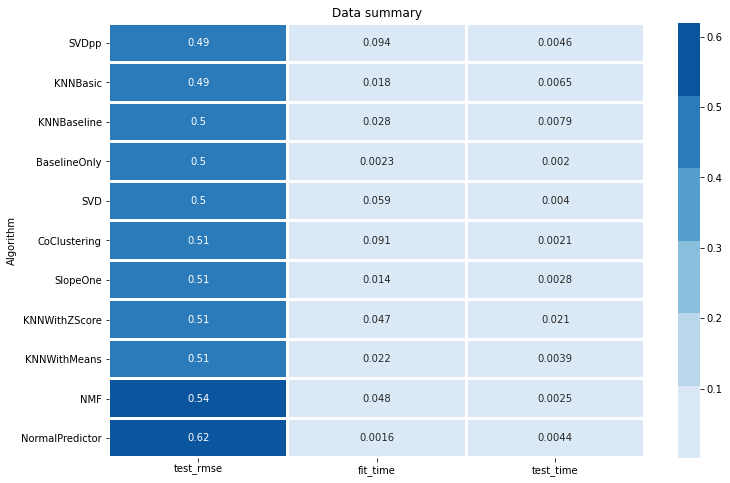

In [16]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
sns.heatmap(resultado,
            annot=True,linecolor="w",
            linewidth=2,cmap=sns.color_palette("Blues"))
plt.title("Data summary")
plt.show()

Algoritmos elejidos, KNNBaseline, KNNBasic, BaselineOnly y SVDpp, son los que menor tiempo de train/test tienen y RMSE. Para implementar se prueba con el conocido SVD por problemas de tamaño de la matriz generada y memoría RAM, se descartó KNN ya que no fue posible correrlo.

#### f.6 Train y Predict con (Big Data) <a class="anchor" id="section_2_1_6"></a>
[Tabla de contenidos](#TOC)

Vamos a emplear el conocido algorítmo SVD en surprise para realizar las prediciones:

In [17]:
## Cargamos el dataset con un rectágulo de los datos
ratings = pd.read_csv('data/df_ratings.csv')
ratings.head()

,product_id,username,app_name,price,hours,score
0,328100,dll3z,Gunspell - Steam Edition,14.99,0.4,0
1,328100,Nyazicat,Gunspell - Steam Edition,14.99,2.2,0
2,328100,novocain,Gunspell - Steam Edition,14.99,3.8,1
3,328100,raixel,Gunspell - Steam Edition,14.99,3.2,1
4,328100,Shwgar,Gunspell - Steam Edition,14.99,1.4,0


In [18]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 1))

Para importar la data, usamos el método `load_form_file`, luego de esto ya tenemos el dataset en formato `surprise` 

In [19]:
ratings = ratings[['username','app_name','score']]
data = Dataset.load_from_df(ratings, reader)
#data.split(n_folds=5)

Usamos el método `train_test_split()` para crear el trainset y testset, y emplearemos la metrica accuracy de RMSE. Luego usamos el método fil() con el cual vamos a entrenar el algoritmo sobre el `trainset`, y el método test() el cual retorna las predicciones hechas sobre el`testset`.

In [20]:
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }

In [21]:
trainset, testset = train_test_split(data, test_size=0.20)
#algo = BaselineOnly(bsl_options=bsl_options)
#algo = KNNBaseline()
algo = SVD()
#predictions = algo.fit(trainset).test(testset)
algo.fit(trainset)

In [22]:
predictions = algo.test(testset)

In [23]:
# Metrica RMSE
accuracy.rmse(predictions)

RMSE: 0.5033


0.5033032000331914

Al finalizar usaremos los datos completos y realizar una validación cruzada para las pruebas. En ese caso, podemos construir un objeto Trainset usando todas las calificaciones con el método build_full_trainset:

In [24]:
trainsetfull = data.build_full_trainset()

In [25]:
print('Número de usuarios: ', trainsetfull.n_users, '\n')
print('Número de items: ', trainsetfull.n_items, '\n')

Número de usuarios:  494795 

Número de items:  9887 



Los usuarios y los elementos tienen una identificación sin formato (`raw id`) y una identificación interna(`inner id`). Algunos métodos usarán/devolverán una identificación sin formato (`raw id`) (por ejemplo, el método predict ()), mientras que otros usarán/devolverán una identificación interna (`inner id`).

Los identificadores sin procesar (`raw id`) son identificadores definidos en un archivo de clasificación o en un dataframe de pandas. Pueden ser cadenas o números. Sin embargo, hay que tener en cuenta que si las calificaciones se leyeron de un archivo, que es el escenario estándar, se representan como cadenas. Es importante saber si está utilizando, por ejemplo, predict() u otros métodos que aceptan ID sin formato (`raw id`) como parámetros.

En la creación del conjunto tainset, cada ID sin formato (`raw id`) se asigna a un número entero único llamado ID interno (`inner id`), que es mucho más adecuado para que Surprise lo manipule. Las conversiones entre ID sin procesar (`raw id`) e internos (`inner id`) se pueden realizar utilizando los métodos: to_inner_uid (), to_inner_iid (), to_raw_uid () y to_raw_iid () del conjunto de trainset.

Para hacer una predicción, usamos las ID sin procesar (`raw id`), por lo que para obtener la calificación estimada del usuario "Chaos Syren" con la identificación de juego "Psi Project", necesita el método de predict() de su algoritmo entrenado:

In [26]:
algo.predict(uid = 'Chaos Syren', iid = 'Psi Project')

Prediction(uid='Chaos Syren', iid='Psi Project', r_ui=None, est=0.5083061762605948, details={'was_impossible': False})

r_ui es None, porque el usuario no tiene actualmente un rating para ese item. `est`, es la calificación estimada en la que estamos interesados, en este caso el rating estimado es de 0.88

#### f.7 Cross Validation <a class="anchor" id="section_2_1_7"></a>
[Tabla de contenidos](#TOC)

Usamos croos-validation para ver si nuestro modelo está overfiteado o no. Vamos a usar la función `cross_validate()`. Pero para un mejor control, instanciamos un iterador de validación cruzada y hacer predicciones sobre cada división usando el método `split()` del iterador y el método `test()` del algoritmo. A continuación usamos un procedimiento de validación cruzada de K-fold clásico con 5 divisiones:

In [27]:
%%capture
# %%capture`, para no mostrar stdout y stderr 

from surprise import accuracy
from surprise.model_selection import KFold

# define a cross-validation iterator
kf = KFold(n_splits=5)

#algo = KNNBaseline()
#algo = BaselineOnly()
algo = SVD()

accuracy_rmse = []

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    #accuracy.rmse(predictions, verbose=False)
    accuracy_rmse.append(accuracy.rmse(predictions, verbose=False))

In [28]:
print(accuracy_rmse)

[0.503493158707715, 0.503267878027859, 0.5032944982653303, 0.5031755596311894, 0.5033679482465782]


No se observa overfiting. Además podemos usar otros iteradores en cross-validation, como `LeaveOneOut` or `ShuffleSplit`.

#### g. Optimización Hiperparámetros <a class="anchor" id="section_2_2"></a>
[Tabla de contenidos](#TOC)

La función `cross_validate()` informa la métrica de precisión sobre un procedimiento de validación cruzada para un conjunto de parámetros dado. Si desea saber qué combinación de parámetros produce los mejores resultados, la clase `GridSearchCV` nos facilita esta tarea. Dado un diccionario de parámetros, esta clase prueba exhaustivamente todas las combinaciones de parámetros e informa los mejores parámetros para cualquier medida de precisión (promediados sobre las diferentes divisiones).

Hay cuatro hiperparámetros que optimicé:

- `n_factors`: este parámetro determina el tamaño de sus vectores pᵤ y qᵢ. Esto determina cuántos factores latentes intentará encontrar el modelo. Cuanto mayor sea el número, más potencia tiene el modelo, pero también tiene una mayor probabilidad de overfitting. <br>
- `n_epochs`: este factor determina cuántas veces se repiten los cálculos de descenso de gradiente. Aumentar este número hace que las predicciones sean más precisas, pero requiere más tiempo para calcularlas.<br>
- `lr_all`: Factor de tasa de aprendizaje para todos los parámetros. Estos son los tamaños de paso que usará el modelo para minimizar la función de costo.<br>
- `reg_all`: factor de regularización para todos los parámetros. Surprise usa una regularización L2, lo que aproximadamente significa que intentará minimizar las diferencias entre el valor al cuadrado de los parámetros. (Los parámetros son todos los bᵤ, bᵢ, pᵤ y qᵢ.)



In [32]:
from surprise.model_selection import GridSearchCV

In [33]:
### diccionario para usar con gridsearch
param_grid = {'n_factors':[10,50,100,150,200],'n_epochs':[20,30],  'lr_all':[0.005,0.01],'reg_all':[0.02,0.1]}

In [34]:
#gridsearch
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)

In [35]:
%%capture
# %%capture`, para no mostrar stdout y stderr 

# hacemos el fit
gs.fit(data)
#gs.fit(trainsetfull)

In [36]:
# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.5017774301322321
{'n_factors': 10, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1}


Una vez que se ha llamado a fit(), el atributo best_estimator nos da una instancia de algoritmo con el conjunto óptimo de parámetros. Aunque se observa que no hay mejora al usar GridSearchCV en el RMSE.

In [37]:
%%capture
# %%capture`, para no mostrar stdout y stderr 
# Obtenemos nuestro modelo entrenado con los mejores parámetros obtenidos a través de GridSearchCV
algo = gs.best_estimator['rmse']
# Entrenamos el modelo con los mejores parametros pero con todo el conjunto de datos
algo.fit(trainsetfull)

#### g.1 Top-10 recommendations para cada usuario <a class="anchor" id="section_2_2_1"></a>
[Tabla de contenidos](#TOC)

A continuación el top-10 items con el valor más alto de rating de predicción para cada usuario del dataset. Entrenamos un modelo con el argoritmo elegido con todo el dataset, y predecimos todos los ratings para todos los pares (usuarios, items) que no están en el set de entrenamiento. Obtenemos el top-1' de las predicciones para cada usuarios.

Sistema recomendador, sacar the top best y el top_worst, con esto puedo sacar una porción del best(80%) que sabemso que le va a gustar y tratar de sorprender al usuario introducien do valores nuevos con el de Worst, así si el usuario llega a dar un me gusta alguno de los items recomendados podemos usar eso para retroalimenar nuestro modelo

In [38]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
#best_predictions = df.sort_values(by='err')[:10]
#worst_predictions = df.sort_values(by='err')[-10:]
best_predictions = df.sort_values(by='err',ascending=True)
worst_predictions = df.sort_values(by='err',ascending=False)

In [39]:
best_predictions.shape

(141461, 8)

#### Mejores predicciones

In [40]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
33120,Cedjoe,Sid Meier's Civilization IV: Colonization,0.0,0.0,{'was_impossible': False},27,18,0.0
114032,Royal Guard,how do you Do It?,1.0,1.0,{'was_impossible': False},1,133,0.0
33406,:thinking:,how do you Do It?,1.0,1.0,{'was_impossible': False},2,133,0.0
33548,Alex,The Cat and the Coup,1.0,1.0,{'was_impossible': False},131,42,0.0
14973,Tony,The Plan,1.0,1.0,{'was_impossible': False},48,80,0.0
...,...,...,...,...,...,...,...,...
139699,Saint Satan,Doorways: The Underworld,1.0,0.0,{'was_impossible': False},21,13,1.0
89266,jpsf91,The Tiny Bang Story,0.0,1.0,{'was_impossible': False},19,73,1.0
97688,Warlok,Republique,0.0,1.0,{'was_impossible': False},7,16,1.0
112175,NishiLion,Space Channel 5: Part 2,0.0,1.0,{'was_impossible': False},15,21,1.0


In [41]:
#best_predictions.est.value_counts()

#### Peores Predicciones

In [42]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
97688,Warlok,Republique,0.0,1.0,{'was_impossible': False},7,16,1.0
62533,Badger,Farming Simulator 2013 Titanium Edition,0.0,1.0,{'was_impossible': False},27,148,1.0
89266,jpsf91,The Tiny Bang Story,0.0,1.0,{'was_impossible': False},19,73,1.0
112175,NishiLion,Space Channel 5: Part 2,0.0,1.0,{'was_impossible': False},15,21,1.0
139699,Saint Satan,Doorways: The Underworld,1.0,0.0,{'was_impossible': False},21,13,1.0
...,...,...,...,...,...,...,...,...
33548,Alex,The Cat and the Coup,1.0,1.0,{'was_impossible': False},131,42,0.0
114032,Royal Guard,how do you Do It?,1.0,1.0,{'was_impossible': False},1,133,0.0
137838,pango,Monsterland,0.0,0.0,{'was_impossible': False},18,1,0.0
64717,KisuShotto,Yohjo Simulator,1.0,1.0,{'was_impossible': False},1,9,0.0


Por ejemplo, las mejores predicciones, lo que le vamos a recomendar al usuario "lemon" serán

In [43]:
mask = best_predictions.loc[:, 'uid'] == 'deburger'
user = best_predictions.loc[mask]
user.head()

,uid,iid,rui,est,details,Iu,Ui,err


In [44]:
#best_predictions[best_predictions['uid'] == 'deburger']

Notar: las predicciones realizadas fueron hechas sobre el conjunto de datos testset, por problemas de computo no se puede crear la matriz completa para todos los pares usarios e items

#### h. Comparacion con el modelo elegido de Benchmark <a class="anchor" id="section_2_3"></a>
[Tabla de contenidos](#TOC)

No se observaron mejoras considerables con respecto a los modelos evaluados como Benchmark. El mejor RMSE obtenido fue de 0.49 con SVDpp, con el modelo empleado para las predicciones el RMSE es de 0.50.

#### i Información para predecir <a class="anchor" id="section_2_4"></a>
[Tabla de contenidos](#TOC)

#### i.1 Como se realizan las predicciones <a class="anchor" id="section_2_4_1"></a>
[Tabla de contenidos](#TOC)

Surprise necesita un conjunto de datos para predecir, con tres variables: identificación de usuario, identificación del artículo y calificación. Esto es importante, no hay que pasar las calificaciones en un formato de matriz de calificaciones de elementos de usuario. El dataset tiene 3 columnas y el número de filas es igual al número total de calificaciones individuales. Se cargó el dataset  con las features user_num, app_num, score.

En el modelo SVD, una calificación estimada del usuario u en el ítem i se calcula como:

<!-- <img src="imagenes/formula_rating_SVD.png" width="200"> -->

![rating formula](https://raw.githubusercontent.com/gonzalogperez/sistemas-recomendacion-steam/main/imagenes/formula_rating_SVD.png)


donde μ es la calificación promedio general, y todos los demás parámetros se calculan a partir del modelo con un método de descenso de gradiente. Por lo tanto, el modelo intentará ajustar esta calificación estimada en todas las calificaciones conocidas, minimizando el RMSE y devolver el valor más cercano. <br>

bᵤ y bᵢ son escalares, representan los sesgos del usuario u o del elemento i. Por ejemplo, el usuario u tiende a desviarse de la calificación promedio general. Estos sesgos se pueden desactivar al ajustar el modelo, que es básicamente lo que es el modelo NMF.<br>

pᵤ y qᵢ son vectores y su longitud es un hiperparámetro del modelo, n. Son la parte real de factorización matricial del modelo. Cada usuario y elemento estará representado por su vector, que intenta capturar su esencia en n números. La calificación se obtiene multiplicando los pares de item-usuario (y agregando promedios y sesgos).


La faltante de datos en la matriz de utilidad complica las cosas. La descomposición de valores singulares (SVD), una factorización de una matriz m x n en sus valores singulares y ortogonales, no está definida si alguna de las entradas en la matriz no está definida. Esto significa que no podemos factorizar explícitamente la Matriz de tal manera que podamos encontrar qué factores diagonales (o latentes) tienen el mayor peso en el conjunto de datos.
En su lugar, se aproxima a la mejor factorización de la matriz, utilizando una técnica llamada **factorización probabilística de matrices**.

La primera será una matriz **P** de m x k, mientras que la segunda será una matriz **Q** de k x n. Cuando estas dos matrices se multiplican entre sí, dan como resultado una matriz de m x n, que es exactamente el tamaño de nuestra matriz de Calificación en la que estamos tratando de predecir. La dimensión k es uno de nuestros hiperparámetros (n_factors), que representa la cantidad de factores latentes que estamos usando para estimar la matriz de calificaciones. Se utilizó GridSearch para encontrar el valor de k anteriormente (valor obtenido con GridSearch `n_factors = 10` ).

<!-- <img src="imagenes/matrixfactorization.png" width="400"> -->
![rating formula](https://github.com/gonzalogperez/sistemas-recomendacion-steam/blob/main/imagenes/matrixfactorization.png?raw=true)

Con las Matrices P, Q, optimizaremos sus valores usando el **Descenso de Gradiente Estocástico**. Por lo tanto, tendrá dos hiperparámetros más para optimizar, la tasa de aprendizaje (lr_all) y las épocas (n_epochs). Para cada Época, vamos a iterar a través de cada calificación conocida en nuestra matriz m x n original.
Luego, obtendremos un valor de error o residual e restando el valor de calificación original por el producto escalar de la fila del usuario de las calificaciones originales en P y la columna de su artículo en Q.

<!-- <img src="imagenes/matrixfactorization2.png" width="350" > -->
![rating formula](https://github.com/gonzalogperez/sistemas-recomendacion-steam/blob/main/imagenes/matrixfactorization2.png?raw=true)

En el modo de descenso de gradiente estocástico normal, actualizaremos ambas matrices P y Q simultáneamente sumando la fila actual para P y Q por la tasa de aprendizaje multiplicada por el producto del error por los valores de la otra matriz.

Los factores latentes representan categorías que están presentes en los datos. Para `k = 10` factores latentes para un conjunto de datos de juegos, estos podrían representar los generos Action, Casual, 
Indie, Simulation, RPG, Strategy, Free to Play, Adventure, etc. Con un k más alta, se obtienen categorías más específicas. Estamos tratando de predecir la calificación del elemento i de un usuario u. Por lo tanto, buscamos en P para encontrar un vector que represente al usuario u, y sus preferencias o "afinidad" hacia todos los factores latentes. Luego, miramos Q para encontrar un vector que represente el elemento i y su "afinidad" hacia todos los factores latentes. Obtenemos el producto escalar de estos dos vectores, que nos devolverá una idea de cuánto le gusta el artículo al usuario en el contexto de los factores latentes.

In [48]:
# Matriz usuarios y factores elegidos <br>
pu = pd.DataFrame(algo.pu)
pu

,0,1,2,3,4,5,6,7,8,9
0,0.034551,-0.019740,-0.161466,0.076070,0.031661,0.083376,-0.053268,0.059457,-0.154998,0.151916
1,0.121667,-0.002473,-0.193735,-0.209082,0.056209,-0.140758,0.258512,-0.006311,0.044403,-0.005237
2,0.190127,0.068640,-0.046218,0.032488,0.044175,0.063390,-0.154815,0.026229,0.095054,0.048848
3,-0.036217,0.018463,-0.311503,-0.066907,-0.103385,-0.081117,0.097386,0.175078,-0.000498,0.176744
4,0.062631,-0.066124,0.010742,-0.047823,-0.071086,-0.146089,0.056616,-0.000899,-0.039262,0.040394
...,...,...,...,...,...,...,...,...,...,...
494790,0.010484,0.084992,-0.086902,-0.170430,0.017728,0.048353,0.091591,0.099714,-0.056128,-0.175517
494791,0.038194,-0.048939,-0.013508,-0.099662,-0.062193,0.160207,0.074660,0.084904,-0.071631,0.035101
494792,-0.022819,-0.089210,-0.011224,-0.160019,-0.025606,0.041767,-0.040299,-0.070486,-0.002361,0.128117
494793,0.033968,-0.202722,-0.013179,-0.077918,0.090035,0.045213,-0.179623,0.084977,-0.136255,-0.007738


In [49]:
# Matriz items y factores elegidos
qi = pd.DataFrame(algo.qi)
qi

,0,1,2,3,4,5,6,7,8,9
0,0.054549,-0.143242,-0.087873,-0.179720,-0.021896,0.144368,0.026860,-0.099225,-0.052619,0.001947
1,-0.291873,-0.184705,0.042320,0.092491,-0.163555,0.114172,0.071911,-0.036785,0.008043,0.031784
2,0.005564,0.025936,-0.007584,0.010712,0.000487,-0.015418,0.004143,-0.005091,-0.015641,0.014189
3,0.008383,-0.162377,0.053298,0.089932,-0.026239,0.046693,-0.091621,0.100919,0.056677,-0.119389
4,-0.010182,-0.034984,-0.119672,0.097904,-0.129838,0.020689,-0.007799,0.119920,-0.040698,0.025717
...,...,...,...,...,...,...,...,...,...,...
9882,-0.101227,0.027537,0.094927,-0.108051,-0.046988,-0.065470,0.070153,0.040124,0.064076,0.047753
9883,-0.017411,0.017005,-0.095393,-0.117734,-0.084720,0.046235,-0.030686,0.048436,-0.098218,-0.052893
9884,-0.058725,0.140160,-0.029125,-0.065656,-0.029213,0.031709,-0.174063,0.003209,0.053770,0.075772
9885,-0.007740,0.112836,-0.078812,-0.147289,0.107829,0.123439,-0.011313,-0.166219,-0.042688,-0.090051


#### i.2 Predicciones similar a populares? <a class="anchor" id="section_2_4_2"></a>
[Tabla de contenidos](#TOC)

Vamos a observar las mejores predicciones (las que tienen menor error) y compararlas con los juegos más populares, es decir, determinar si guardan realación.

In [ ]:
#df_test = pd.DataFrame(testset,
#               columns =['username', 'app_name','ratting'])
#df_test

In [ ]:
best_predictions

In [ ]:
#Observamos las mejores predicciones que no tienen que ver con los juegos más populares
best_predictions[best_predictions['est'] == 1 ][:20]

In [ ]:
#Observamos las mejores predicciones que no tienen que ver con los juegos más populares
best_predictions[best_predictions['est'] == 1 ].sort_values(by='Ui', ascending=False)[:10]

Obtenemos el top 20 de los items con mejores predicciones recomendados ordenados por la cantidad de recomendaciones

In [ ]:
best_top = best_predictions.loc[(best_predictions['est'] == 1)  & (best_predictions['err'] == 0),['iid','Ui']].sort_values(by='Ui', ascending=False)[:20]

In [ ]:
best_top['iid'].unique()

Juegos más populares según el número de usuarios

In [ ]:
df = pd.read_csv('data/df_ratings.csv')
df.shape

# relizamos conteno por nombre del juego y luego ordenamos de manera descendente
df_top = df.app_name.value_counts().sort_values(ascending = False)

df_top = pd.DataFrame(df_top)
df_top['top_game'] = df_top.index
df_top.rename({'app_name': 'cnt'}, axis=1, inplace=True)
df_top.reset_index(drop=True, inplace=True)
df_top = df_top[['top_game','cnt']].sort_values(['cnt'], ascending=False)
df_top.head(10)

In [ ]:
df_top.top_game[:20]

Top_N de las predicciones

In [ ]:
best_pred_top =  best_predictions.groupby('iid')['uid'].agg('count').sort_values(ascending=False)
#best_pred_top

In [ ]:
best_pred_top = pd.DataFrame(best_pred_top)
best_pred_top['app_name'] = best_pred_top.index
best_pred_top.rename({'uid': 'cnt'}, axis=1, inplace=True)
best_pred_top.reset_index(drop=True, inplace=True)
#best_pred_top.head(10)
best_pred_top = best_pred_top[['app_name','cnt']].sort_values(['cnt'], ascending=False)
best_pred_top.head(10)

In [ ]:
top_n=20
## creamos la figura con subplots de 1 linea 2 columnas
fig, axes = plt.subplots(2, figsize=(20, 14))
fig.suptitle('Top 10 de los juegos más recomendados', fontsize=24)
#padding between subplots. Pass a float parameter to specify the amount of padding between subplots.
#fig.tight_layout(pad=1.0)

# GRacount 0
#sns.countplot(data = df_top, x = "top_game", orient='v', ax=axes, order = df_top['cnt'].value_counts().index)
sns.barplot(x="app_name", y="cnt", ax=axes[0],orient="v", data=best_pred_top.head(top_n))
#axes.set_title("Todas los tipos: ",fontsize = 10, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
#plt.sca(axes[0, 1])
axes[0].set_title("TOP Recomendados",fontsize = 14, color = "w", fontstretch=0, backgroundcolor="SteelBlue")

plt.sca(axes[0])
plt.xticks(rotation=90)
plt.grid()

for rect in axes[0].patches:
    axes[0].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)
    
######################################    
fig.tight_layout(pad=5.0)
  
# GRacount 0
#sns.countplot(data = df_top, x = "top_game", orient='v', ax=axes, order = df_top['cnt'].value_counts().index)
sns.barplot(x="top_game", y="cnt", ax=axes[1],orient="v", data=df_top.head(top_n))
#axes.set_title("Todas los tipos: ",fontsize = 10, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
#plt.sca(axes[0, 1])
axes[1].set_title("TOP Populares",fontsize = 14, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
plt.sca(axes[1])
plt.xticks(rotation=90)
plt.grid()

for rect in axes[1].patches:
    axes[1].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)
    

Hasta el top 5 el sistema recomiendo los más populares hasta respeta el orden.

In [ ]:
#best_pred_top.shape
#best_pred_top.cnt.sum()

Corroboramos si los recomendados se encuentran en el top de los más populares. 

In [ ]:
list1 = list(df_top.top_game[:20])
list2 = list(best_pred_top.app_name[:20])
list(set(list1) - set(list2))

Conclusión: Con SVD, el sistema de recomendación termina devolviendo los más populares como recomendación, por lo menos es así en el top 20 analizado.

### Investigación <a class="anchor" id="chapter3"></a>

#### j. Plantea nuevas preguntas en base al trabajo que hiciste y en las que se pueda ahondar <a class="anchor" id="section_3_1"></a>
[Tabla de contenidos](#TOC)

1- Como funcionaría el sistema para un usuario que recién ingresa a la plataforma, es decir el cold start <br>
2- Como realizamos una recomendación trabajando con big data?

#### k. Plantea un flujo de trabajo que responda alguna o algunas de esas preguntas <a class="anchor" id="section_3_2"></a>
[Tabla de contenidos](#TOC)

1- Probar el modelo con usuarios nuevos y ver su comportamiento, es decir un usuario que esté en test y no en train, la predicciones tendrían que ser malas. Entonces que hacer allí? que modelo emplear o técnica para recomendar. Podríamos probar recomendarles a los usuario nuevos los juegos más populares y de acuerdo a si eligen uno de los recomendados, se lo puede considerar que lo han calificado positivo, y utilizar esa información para retroalimentar al modelo y volverle a recomendar nuevos juegos

2- Entrenamos el modelo con todo el conjunto de datos, como no es posible realizar las predicciones para todos los pares usuario/items por problemas de computo, se procederá a crear una función a la cual se le pase el usuario sobre el cual se quiera realizar las predicciones, devolviendo las predicciones para todos los items ordenadas según el criterio especificado.

### Requerimientos Adicionales <a class="anchor" id="chapter4"></a>
#### l. Implementa el flujo de trabajo planteado <a class="anchor" id="section_4_1"></a>
[Tabla de contenidos](#TOC)

#### l.1 Cold Start <a class="anchor" id="section_4_1_1"></a>

Sistema de recomendación Basado en Popularidad para los usuarios nuevos a la plataforma.

Para los nuevo usuarios de la plataforma de Steam, no conocemos nada, la forma más eficiente para esos usuarios de hacerles conocer de la plataforma es de ofrecerles los juegos más populares según los usuarios previos. Además, estos juegos no tienen limitación de tiempo. Son los juegos juegos más populares desde el tiempo de su aparición en la plataforma.

1. Primero necesitamos extraer 'product_id','username','app_name','price', luego extraer la información del top 100 de los juegos.
2. Luego ordenamos los juegos en orden descendente acuerdo al número de propietarios (Es decir, que el juego con más propietarios, es el juego más popular)

Probamos con pocos datos:

In [146]:
#df = pd.read_csv('data/pruebaUsers.csv', nrows=10000)
df = pd.read_csv('data/df_ratings.csv')
df.shape

(707305, 6)

In [147]:
df1 = df[['product_id','username','app_name','price','hours']]

In [148]:
#data_games = pd.read_csv('data/pruebaGames.csv', nrows=1000)

In [149]:
df1.head()

,product_id,username,app_name,price,hours
0,328100,dll3z,Gunspell - Steam Edition,14.99,0.4
1,328100,Nyazicat,Gunspell - Steam Edition,14.99,2.2
2,328100,novocain,Gunspell - Steam Edition,14.99,3.8
3,328100,raixel,Gunspell - Steam Edition,14.99,3.2
4,328100,Shwgar,Gunspell - Steam Edition,14.99,1.4


#### Juegos más populares según la cantidad de usuarios
A continuación se muestra el ranking de los juegos más populares en la plataforma Steam.

In [150]:
# relizamos conteno por nombre del juego y luego ordenamos de manera descendente
df_top = df1.app_name.value_counts().sort_values(ascending = False)

df_top = pd.DataFrame(df_top)
df_top['top_game'] = df_top.index
df_top.rename({'app_name': 'cnt'}, axis=1, inplace=True)
df_top.reset_index(drop=True, inplace=True)
df_top = df_top[['top_game','cnt']].sort_values(['cnt'], ascending=False)
df_top.head(10)

,top_game,cnt
0,Team Fortress 2,17317
1,Rust,9244
2,Borderlands 2,6760
3,Fallout 4,6554
4,Grand Theft Auto V,5545
5,Undertale,5282
6,Warframe,5155
7,Portal 2,5023
8,DayZ,4976
9,Robocraft,4765


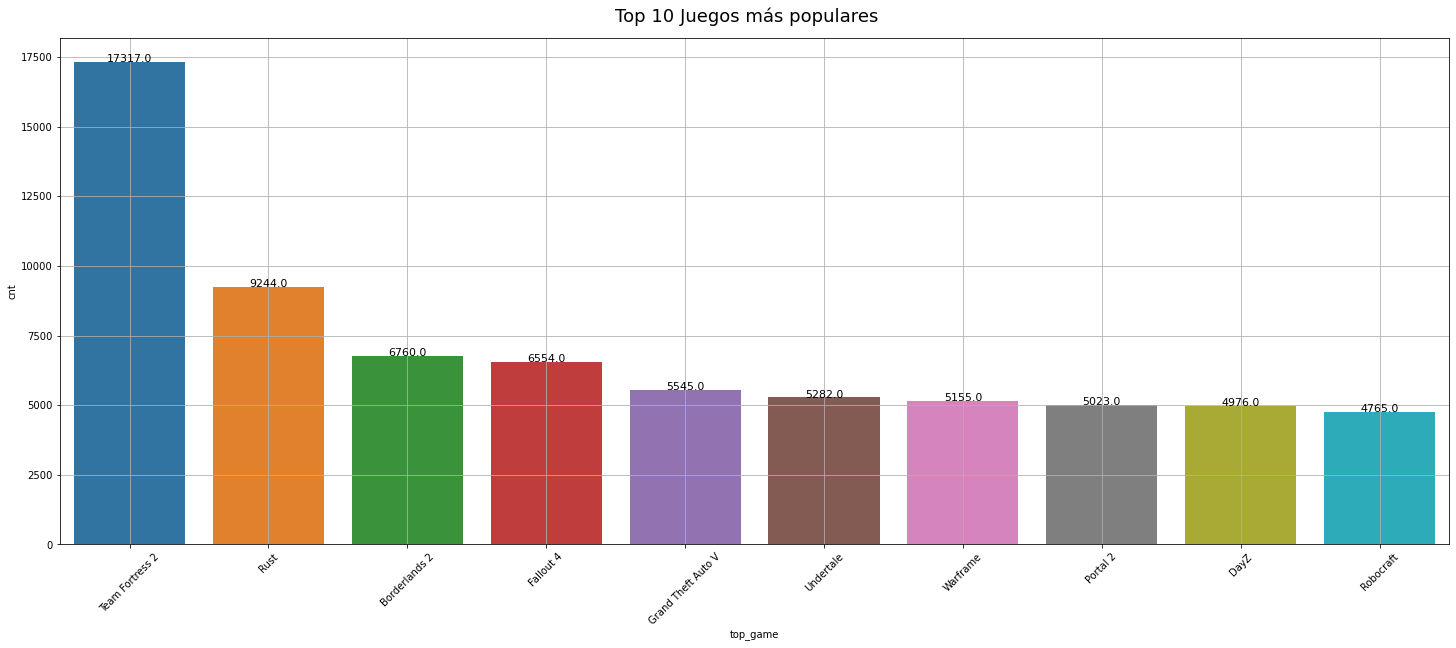

In [151]:
## creamos la figura con subplots de 1 linea 2 columnas
fig, axes = plt.subplots(1,1, figsize=(20, 8))
fig.suptitle('Top 10 Juegos más populares', fontsize=18)
#padding between subplots. Pass a float parameter to specify the amount of padding between subplots.
fig.tight_layout(pad=1.0)

# GRacount 0
#sns.countplot(data = df_top, x = "top_game", orient='v', ax=axes, order = df_top['cnt'].value_counts().index)
sns.barplot(x="top_game", y="cnt", ax=axes,orient="v", data=df_top.head(10))
#axes.set_title("Todas los tipos: ",fontsize = 10, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
#plt.sca(axes[0, 1])
plt.sca(axes)
plt.xticks(rotation=45)
plt.grid()

for rect in axes.patches:
    axes.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)


Es decir, a los clientes que recién ingresen a la plataforma se le recomendará los juegos más populares, tomado del top_10 de manera aleatoria:

In [152]:
import random

#print(random.randrange(10))
def reco_new_user():
    #print(df_top.top_game[random.randrange(10)])
    return df_top.top_game[random.randrange(10)]

In [154]:
print("Recomendación usuario nuevo a la plataforma:")
reco_new_user()

Recomendación usuario nuevo a la plataforma:


'DayZ'

#### l.2 Como realizamos las predicciones en Big Data? <a class="anchor" id="section_4_1_2"></a>
[Tabla de contenidos](#TOC)


Se descartó la opción de crear un diccionario con el top-N recomendaciones para cada usuario desde el set de datos de las predicciones. 

Predecir los ratings para todos los pares (u,i) que NO están en el conjunto de entrenamiento.

In [34]:
#testset = trainset.build_anti_testset()
#predictions = algo.test(testset)

Las líneas anteriores no se pudieron correr por problemas de memoría RAM, se probó en GoogleColabs y tampoco se logró culinar el proceso por falta de memoría RAM. Por lo cual, las predicciones solo se realizaron sobre el conjunto de testset obtenido del train_test_split.

In [210]:
#Cargamos nuevamente el dataset de los ratings
df = pd.read_csv('data/df_ratings.csv')

In [211]:
#vemos los juegos adquiridos por el usuarios
df[df['username'] == 'lemon']

,product_id,username,app_name,price,hours,score
146461,242940,lemon,Anachronox,6.99,11.7,1
229258,255280,lemon,1954 Alcatraz,9.99,2.2,0
411426,22300,lemon,Fallout 3,9.99,7.9,0
442175,6550,lemon,Devil May Cry® 3 Special Edition,19.99,6.5,1
458959,318860,lemon,Malebolgia,12.99,0.4,0
649234,4500,lemon,S.T.A.L.K.E.R.: Shadow of Chernobyl,19.99,35.4,1
672731,252490,lemon,Rust,19.99,1.3,0


In [212]:
df_original = pd.read_csv('data/mergeado.csv')

In [213]:
df_original[df_original['username'] == 'lemon']

,product_id,username,hours,products,app_name,price,genres,tags,specs
162158,242940,lemon,11.7,347.0,Anachronox,6.99,['RPG'],"['RPG', 'Cyberpunk', 'Sci-fi', 'Comedy', 'Clas...",['Single-player']
253169,255280,lemon,2.2,174.0,1954 Alcatraz,9.99,"['Adventure', 'Indie']","['Adventure', 'Point & Click', 'Indie', 'Singl...","['Single-player', 'Steam Achievements', 'Steam..."
453298,22300,lemon,7.9,287.0,Fallout 3,9.99,['RPG'],"['Open World', 'Post-apocalyptic', 'RPG', 'Sin...","['Single-player', 'Partial Controller Support']"
487421,6550,lemon,6.5,347.0,Devil May Cry® 3 Special Edition,19.99,['Action'],"['Action', 'Hack and Slash', 'Stylized', 'Grea...","['Single-player', 'Partial Controller Support']"
505790,318860,lemon,0.4,347.0,Malebolgia,12.99,"['Action', 'Adventure', 'Indie']","['Adventure', 'Indie', 'Action', 'Horror']","['Single-player', 'Steam Achievements', 'Steam..."
716134,4500,lemon,35.4,347.0,S.T.A.L.K.E.R.: Shadow of Chernobyl,19.99,"['Action', 'RPG']","['Atmospheric', 'Post-apocalyptic', 'Open Worl...","['Single-player', 'Multi-player']"
742124,252490,lemon,1.3,68.0,Rust,19.99,"['Action', 'Adventure', 'Indie', 'Massively Mu...","['Early Access', 'Survival', 'Crafting', 'Mult...","['Multi-player', 'MMO', 'Cross-Platform Multip..."


Observamos que al usuario lemon le gustan los juegos de Accion y RPG. El sistema de recomendación a acertado en la predicción y recomendó un Juego que el usuario consumiría.

Al no poder correr un `predict` sobre todo el conjunto de datos, es decir completar la matriz de usuarios/items con todas las calificaciones faltantes por cuestiones de computo (no se le encontró mucho sentido a esto), y para poder entrenar al algorítmo con todo el dataset (se usa el trainsetfull) y luego realizar las predicciones sobre un usuario en particular, obteniendo así las mejores estimaciones.

In [105]:
# Tomamos todos los nombre de los items (juegos)
nom_juegos = df['app_name'].unique()
nom_juegos.shape

(9887,)

Creamos una funcion get_predictions_one_user` que utilizamos para obener las predicciones para el usuario indicado sobre todos los items

In [204]:
# Creamos una funcion get_predictions_one_user` que utilizamos para obener las predicciones para el usuario indicado sobre todos los items

def get_predictions_one_user(user,xoy):
    """ Retorna las predicciones para un usuario específico y todos los items
    args: 
      user: el nombre del usuario
      xoy: tipo de resultado a devolver, best o worst
    returns: 
      las predicciones para ese usuario de todos los items
    """
    predictions_one_user=[]
    for i in tqdm(range(0,nom_juegos.shape[0])):
        app_name_i = nom_juegos[i]
        #print("app_name_i",app_name_i)
        result = algo.predict(uid = user, iid = app_name_i)
        #print(algo.predict(uid = 'lemon', iid = app_name_i))
        predictions_one_user.append(result)
        
    df = pd.DataFrame(predictions_one_user, columns=['uid', 'iid', 'rui', 'est', 'details'])
    df['Iu'] = df.uid.apply(get_Iu)
    df['Ui'] = df.iid.apply(get_Ui)
    df['err'] = abs(df.est - df.rui)
    if xoy == 'best':
        best_predictions = df.sort_values(by='est')[:5]
        return best_predictions['iid']
    elif xoy == 'worst':
        worst_predictions = df.sort_values(by='est')[-5:]
        return worst_predictions['iid']
    else:
        print("Debe ingresar como segundo argumento best o worst")

Por ejemplo, los 5 juegos recomendados para el usuario `lemon` son:

In [205]:
predict_x = get_predictions_one_user('lemon', 'best')

  0%|          | 0/9887 [00:00<?, ?it/s]

In [217]:
# Juegos recomendados para el usuario x
predict_x.reset_index(drop=True,inplace=True)
predict_x

0                 Stream Avatars
1                           Ziro
2                  Gaben Kingdom
3    Achievement Hunter: Pharaoh
4         Ruzar - The Life Stone
Name: iid, dtype: object

In [214]:
#df_original[(df_original['app_name'].isin(predict_x)) ]

#### l.3 Conclusiones <a class="anchor" id="section_4_1_3"></a>
[Tabla de contenidos](#TOC)

El sistema de recomendación por filtro colaborativo requiere gran cantidad de computo, sobre todo de memoria RAM. Para generar la matriz con todas las predicciones, es decir crear un testsetfull. Como no se le encontró sentido de generar las predicciones para todo el conjunto (completar la matriz), se entrenó el modelo con `data.build_full_trainset` y luego se realizaron las predicciones para usuarios específicos mediente una función creada `get_predictions_one_user`. Es decir que cada vez que se invoque la función pasandole como argumento el user, retornará las predicciones para todos los pares de ese usuario x y todos los items (todos los juegos) pero solo nos quedaremos con las que mejor estimación tengan (rating positivo, más cercano a 1).